In [1]:
# import os
import SunStatistics as SS
from scipy.stats import pearsonr
%matplotlib notebook
import statsmodels.api as sm
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta,datetime
import pytz
from scipy.optimize import curve_fit

import matplotlib as mpl
mpl.rcParams["mathtext.default"]='regular'

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

G_Drive = 'G:\\My Drive\\'
G_Drive = 'C:\\Users\\User\\Google Drive\\'
Output_Path = G_Drive+'FishIsland_Outputs/'



In [2]:
from scipy.stats import pearsonr, spearmanr,kendalltau

def r_pvalues(df,method='pearson',L=3):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    rvalues = dfcols.transpose().join(dfcols, how='outer')
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            if method == 'spearman':
                rvalues[r][c] = round(spearmanr(df[r], df[c])[0], L)
                pvalues[r][c] = round(spearmanr(df[r], df[c])[1], L)
            elif method == 'kendall':
                rvalues[r][c] = round(kendalltau(df[r], df[c])[0], L)
                pvalues[r][c] = round(kendalltau(df[r], df[c])[1], L)
            else:
                rvalues[r][c] = round(pearsonr(df[r], df[c])[0], L)
                pvalues[r][c] = round(pearsonr(df[r], df[c])[1], L)
    
    return rvalues,pvalues

# Model Functions

In [3]:
def Model_Test_RF(X,y,AllData,K=10,Task = 'Predict',min_samples_split=None,Verbose=True,random_state=1):
    Data = AllData[X+y].dropna()
    kf = KFold(n_splits=K,shuffle=True, random_state = random_state)
    R2 = []
    MSE = []
    Imp = []    
    Pred = []
    rnd=1
    for train_index, test_index in kf.split(Data):
        df_test = Data.iloc[test_index]
        df_train = Data.iloc[train_index]
        X_train = np.array(df_train[X])#.reshape(-1, 1)     
        y_train = np.array(df_train[y]).ravel()#.reshape(-1, 1)
        X_test = np.array(df_test[X])#.reshape(-1, 1)  
        y_test = np.array(df_test[y]).ravel()#.reshape(-1, 1)
        Mod = RandomForestRegressor(min_samples_split=min_samples_split, random_state=random_state+rnd)#,bootstrap=False)
        rnd+=1
        Mod.fit(X_train, y_train)
        Test = Mod.predict(X_test)
        Pred.append(Mod.predict(AllData[X]))
        R2.append(metrics.r2_score(y_test,Test))
        MSE.append(metrics.mean_squared_error(y_test,Test))
        Imp.append(Mod.feature_importances_)
    Imp = np.mean(np.array(Imp),axis=0)
    Pred = np.mean(np.array(Pred),axis=0)
    if Verbose == True:
        print()
        print(y[0])
        print('RMSE', np.mean(np.array(MSE)**.5))
        print('std RMSE', np.std(np.array(MSE)**.5))
        print('r2', np.median(np.array(R2)))
        print('Imp',np.round(Imp,3)*100)
    if Task == 'Predict':
        return(Pred)
    if Task == 'Predict_Return':
        return(Pred,Imp,MSE,R2)
    elif Task == 'Optimize':
        return(MSE)

def Model_Test_OLS(X,y,AllData,K=10,Task = 'Predict',fit_intercept=None,Scale=False,Verbose=True,random_state=1):
    if Scale==True:
        Mod = make_pipeline(StandardScaler(), LinearRegression(fit_intercept=fit_intercept))
    else:
        Mod = make_pipeline(LinearRegression(fit_intercept=fit_intercept))
    Data = AllData[X+y].dropna()
    kf = KFold(n_splits=K,shuffle=True, random_state = random_state)
    R2 = []
    MSE = []
    Int = []
    Coef = []
    Pred = []
    for train_index, test_index in kf.split(Data):
        df_test = Data.iloc[test_index]
        df_train = Data.iloc[train_index]
        X_train = np.array(df_train[X])#.reshape(-1, 1)     
        y_train = np.array(df_train[y])#.reshape(-1, 1)
        X_test = np.array(df_test[X])#.reshape(-1, 1)  
        y_test = np.array(df_test[y])#.reshape(-1, 1)
        Mod.fit(X_train, y_train)
        Test = Mod.predict(X_test)
        if y == ['VPD'] or y == ['PPFD_Avg']:
            Test[Test<0]=0
        
        R2.append(metrics.r2_score(y_test,Test))
        MSE.append(metrics.mean_squared_error(y_test,Test))
        Pred.append(Mod.predict(AllData[X]))
        Int.append(Mod[-1].intercept_)
        Coef.append(Mod[-1].coef_)
    Coef = np.mean(np.array(Coef),axis=0).mean(axis=0)
    Pred = np.mean(np.array(Pred),axis=0)#.mean(axis=0)
    Int = np.mean(np.array(Int))
    if Verbose == True:
        print()
        print(y[0])
        print('RMSE', np.mean(np.array(MSE)**.5))
        print('std RMSE', np.std(np.array(MSE)**.5))
        print('r2', np.median(np.array(R2)))
        print('coef', Coef)
        print('int',Int)
    if Task == 'Predict':
        return(Pred)#.values)
    if Task == 'Predict_Return':
        return(Pred,Coef,Int,MSE,R2)
    elif Task == 'Optimize':
        return(MSE)
    
def Model_Test(X,y,AllData,K=10,Task = 'Predict',Test = 'OLS',min_samples_split=None,fit_intercept=True,Scale=False,Verbose=True,random_state=1):
    if Test == 'OLS':
        return(Model_Test_OLS(X,y,AllData,K=10,Task = Task,fit_intercept=fit_intercept,Scale=Scale,Verbose=Verbose,random_state=random_state))
    elif Test == 'RF':
        return(Model_Test_RF(X,y,AllData,K=10,Task = Task,min_samples_split=min_samples_split,Verbose=Verbose,random_state=random_state))
    

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues


In [4]:

def get_uv(Dir,U_bar,dec=0):
    M_dir = 270-(Dir+dec)
    U = np.cos(M_dir/180*np.pi)*U_bar
    V = np.sin(M_dir/180*np.pi)*U_bar
    return(U,V)
def get_wDir(u,v,m_dec=0):
    W_dir = np.arctan2(v,u)*180/np.pi
    W_dir = 270 - W_dir    
    W_dir[W_dir>360]-=360
    return(W_dir)

# Data

In [5]:
Taglu_Data = Output_Path+'Taglu_Data/Hourly.csv'
AWS = pd.read_csv(Taglu_Data,
parse_dates={'datetime':['Year','Month','Day','Time']}, 
).set_index('datetime')

print(AWS.loc[((AWS.index.month<5)|(AWS.index.month>9)),
              ['Wind Speed']].isnull().sum()/AWS.loc[((AWS.index.month<5)|(AWS.index.month>9)),
                                                     ['Wind Speed']].count())
# Gap Fill
C=['Air Temp','Net Radiation','Net SW Radiation','Net LW Radiation ','Wind Speed','Wind direction']
s = AWS.index.to_series()
print('Missing')
for c in C:
    print('Winter')
    print(c,AWS.loc[((AWS.index.month<5)|(AWS.index.month>10)),c].isnull().sum())
    print('Summer')
    print(c,AWS.loc[((AWS.index.month>=5)&(AWS.index.month<=10)),c].isnull().sum())
    miss = AWS[c].isna()
    #create consecutive groups
    g = miss.ne(miss.shift()).cumsum()
    #aggregate minimal 
    m1 = s.groupby(g).min()
    #get minimal of next groups, last value is replaced last value of index
    m2 = m1.shift(-1).fillna(AWS.index[-1])
    #get difference, convert to minutes
    out = m2.sub(m1).dt.total_seconds().div(3600).astype(int)
    AWS['Temp_Gap'] = g.map(out)
    AWS['Temp']=AWS[c].interpolate()
    AWS.loc[AWS['Temp_Gap']<=4,c]=AWS.loc[AWS['Temp_Gap']<=4,'Temp']
    AWS['Temp1']=AWS[c].shift(24)
    AWS['Temp2']=AWS[c].shift(-24)
    AWS.loc[AWS['Temp_Gap']>=4,c].fillna(AWS.loc[AWS['Temp_Gap']>=4,['Temp1','Temp2']].mean(axis=1))
AWS = AWS.drop(columns=['Temp_Gap','Temp','Temp1','Temp2'])
AWS_Rename = {'Air Temp':'Air_Temp',
              'Rainfall':'Rainfall',
              'Wind Speed':'Wind_Speed',
              'Wind direction':'Wind_Direction',
              'Net SW Radiation':'Net_SW',
              'Net LW Radiation ':'Net_LW',
              'Net Radiation':'Net_RN'}
AWS = AWS.rename(columns=AWS_Rename)
AWS_cols = list(AWS_Rename.values())

LAT = 69.371182
LON = -134.880935
TZ = -6

Temp = AWS[['Net_SW']].resample('5T').asfreq()
D = Temp.index.floor('D').to_julian_date()
T = Temp.index.hour/24+Temp.index.minute/60/24
A = np.ones(D.shape[0])

Zenith,Angle,Angle_Corr,Azimuth,Sunrise,Sunset=SS.SunStats(LAT*A,LON*A,D.values,T.values,TZ*A)
Temp['Sun_Angle'] = Angle_Corr
Temp = Temp.resample('30T').mean()

Temp['Daytime_Mask']=0.0
Temp.loc[Temp['Sun_Angle']>-0.5,'Daytime_Mask']=1.0

print(Temp.groupby('Daytime_Mask').count()['Sun_Angle'])
Temp = Temp.resample('H').mean()
print(Temp.groupby('Daytime_Mask').count()['Sun_Angle'])

try:
    AWS = AWS.drop(columns=['Sun_Angle','Daytime_Mask'])
except:
    pass
AWS = AWS.join(Temp[['Sun_Angle','Daytime_Mask']])

AWS['Daytime']=0
AWS.loc[AWS['Sun_Angle']>-0.5,'Daytime']=1


Mt = pytz.timezone('Canada/Mountain')
UTC = AWS.index+timedelta(hours=6)
AWS = AWS.set_index(UTC)
AWS.index = AWS.index.tz_localize(pytz.utc).tz_convert(Mt)

U,V = get_uv(AWS['Wind_Direction'],AWS['Wind_Speed'])
AWS['U_bar_AWS'] = U
AWS['V_bar_AWS'] = V
## 


print('Bad SW Fix',AWS.loc[AWS['Net_SW']<-5,'Net_SW'].count())
AWS['SW_Flag'] = np.nan
AWS.loc[AWS['Net_SW']<-5,'SW_Flag']=1
# AWS.loc[AWS['Net_SW']<=-5,'Net_RN']=AWS.loc[AWS['Net_SW']<=-5,['Net_SW','Net_LW']].sum(axis=1)


# print('Bad SW Fix',AWS.loc[AWS['Net_SW']<-5,'Net_SW'].count())
# AWS.loc[AWS['Net_SW']<-5,'Net_SW']=-5
# AWS.loc[AWS['Net_SW']<=-5,'Net_RN']=AWS.loc[AWS['Net_SW']<=-5,['Net_SW','Net_LW']].sum(axis=1)

AWS.groupby('Daytime').count()['Air_Temp']

AWS.groupby('Daytime').describe()['Net_SW']

# plt.figure()
# AWS.loc[['Net_SW']].boxplot()

Wind Speed    0.019939
dtype: float64
Missing
Winter
Air Temp 0
Summer
Air Temp 40
Winter
Net Radiation 0
Summer
Net Radiation 40
Winter
Net SW Radiation 0
Summer
Net SW Radiation 40
Winter
Net LW Radiation  0
Summer
Net LW Radiation  40
Winter
Wind Speed 1180
Summer
Wind Speed 40
Winter
Wind direction 2151
Summer
Wind direction 292


C:\Users\User\FishIsland_Flux_Analysis\FluxProcessing\SunStatistics.py:25: RuntimeWarning: invalid value encountered in arccos
  W2 = np.degrees(np.arccos(np.cos(np.radians(90.833))/(np.cos(np.radians(LAT))*np.cos(np.radians(T2)))-np.tan(np.radians(LAT))*np.tan(np.radians(T2)))) #HA Sunrise (deg)


Daytime_Mask
0.0     99673
1.0    109924
Name: Sun_Angle, dtype: int64
Daytime_Mask
0.0    48317
0.5     3039
1.0    53443
Name: Sun_Angle, dtype: int64
Bad SW Fix 913


,count,mean,std,min,25%,50%,75%,max
Daytime,,,,,,,,
0,49891.0,-1.059278,0.995982,-6.49,-1.7200,-0.93,-0.290,12.26
1,54870.0,114.526946,146.984158,-197.70,12.2925,56.14,152.075,681.10


# EC Data
## Merge

- Eddypro outputs have left labels (half hour timestamp corresponds to end of interval)
    * https://www.licor.com/documents/1ium2zmwm6hl36yz9bu4
- Need to close the right interval to match with AWS

In [6]:
EC_Data = pd.read_csv(Output_Path+'FI_Footprints_2022-02-23_2000mx2m.csv',delimiter = ',',header = 0,na_values = -9999,
                   index_col=['datetime'],
                  ).drop('Unnamed: 0',axis=1)
EC_Data = EC_Data.set_index(pd.to_datetime(EC_Data.index, utc=True)).tz_convert(Mt)
EC_Data = EC_Data.rename(columns={'Daytime':'Daytime_Raw',
                                 'Sun_Angle':'Sun_Angle_Raw'})


EC_Data['Polygon_Obs'] = EC_Data['Polygon'].copy()
EC_Data['Rim_Obs'] = EC_Data['Rim'].copy()

EC_Data.loc[EC_Data['flowrate_mean']<0.0001,['VPD','Tdew']] = np.nan

U,V=get_uv(EC_Data['wind_dir'],EC_Data['wind_speed'],dec=-22)
EC_Data['U_bar_EC']=U
EC_Data['V_bar_EC']=V

FSO = pd.read_csv(Output_Path+'Skeeter_et_al_2022_Day_Fix.csv',
                  index_col=['datetime']).drop('Unnamed: 0',axis=1)#.drop('datetime.1',axis=1)

FSO = FSO.set_index(pd.to_datetime(FSO.index, utc=True)).tz_convert(Mt)
FSO = FSO.rename(columns={'NEE_est':'NEE_FSO',
                            'NME_est':'NME_FSO'})
EC_Data = EC_Data.join(FSO[['NEE_FSO',
'NME_FSO']])

EC_Data['dmx']= EC_Data.index.dayofyear*1000+EC_Data.index.hour+0

EC_Data['DMX'] = EC_Data['dmx'].shift(1)

kwargs = {'closed':'right','label':'left'}
EC_Data_r=EC_Data.resample('h',**kwargs).mean()
EC_Data_r['Rain_mm_Tot']=EC_Data.resample('h',**kwargs).sum()['Rain_mm_Tot']

EC_Data_r = EC_Data_r.drop(['Wind_Direction', 'Wind_Speed'],axis=1)



EC_Data_r_mask = EC_Data.resample('h',**kwargs).count()[['fco2','fch4']]
EC_Data_r_mask['DMX'] = EC_Data.resample('h',**kwargs).min()['DMX']



EC_Data_r_mask.loc[EC_Data_r_mask['fco2']<2,'fco2']=np.nan
EC_Data_r_mask.loc[EC_Data_r_mask['fch4']<2,'fch4']=np.nan

EC_Data_r_mask[['fco2','fch4']]/=2
EC_Data_r['fco2']*=EC_Data_r_mask['fco2']
EC_Data_r['fch4']*=EC_Data_r_mask['fch4']

print(EC_Data_r[['fco2','co2_flux','fch4','ch4_flux']].count())

Data_M1 = EC_Data_r[
                    ['Temp_15_1','Temp_15_2','Temp_5_1','Temp_5_2','Table_1','VWC_1','Tdew','VPD','H','RH',
                    'AirTC_Avg','PPFD_Avg','NR_Wm2_Avg','Rain_mm_Tot','Active_Layer_1',
                    'wind_speed','u*','U_bar_EC','V_bar_EC','Polygon','Rim','air_temperature',
                     'Polygon_Obs','Rim_Obs',
                    'fch4','fco2','NEE_FSO','NME_FSO','ch4_flux','co2_flux']
                    ].join(AWS,how='outer')
Data_M1.head()

print((EC_Data_r[['fco2','co2_flux','fch4','ch4_flux']].count()/EC_Data_r.shape[0]).round(2))

print(Data_M1['fco2'].groupby(Data_M1['Daytime_Mask']).count())

Kx = EC_Data.index.dayofyear*10000+EC_Data.index.hour*100+EC_Data.index.minute
EC_Data['Kx'] = Kx
Kx2 = EC_Data.index.dayofyear*10000+EC_Data.index.hour*100+EC_Data.shift(1).index.minute
EC_Data['Kx2'] = EC_Data['Kx'].shift(1)
# EC_Data.loc[EC_Data.index.minute+0==30,Kx]# = EC_Data.loc[EC_Data.index.minute==30,Kx2]

EC_Data.loc[EC_Data.index.minute==30,'Kx']=np.nan
EC_Data.loc[EC_Data.index.minute==0,'Kx2']=np.nan
EC_Data['Kx']=EC_Data['Kx'].ffill()
EC_Data['Kx2']=EC_Data['Kx2'].bfill()
# EC_Data[['Kx','Kx2']].shape




fco2        1164
co2_flux    1337
fch4         653
ch4_flux     788
dtype: int64
fco2        0.59
co2_flux    0.67
fch4        0.33
ch4_flux    0.40
dtype: float64
Daytime_Mask
0.0     103
0.5      17
1.0    1044
Name: fco2, dtype: int64


# ECMWF, Satelite & Stream

- ECMWF data does not account for DST
    - Must offset by one hour so summer times match

In [7]:
ECMWF = pd.read_csv(G_Drive+'earthengine//Climate_Weighted_Mean_long.csv',
                    parse_dates=['system:index'],na_values=-9999,index_col=['system:index'])

UTC = ECMWF.index+timedelta(hours=-1)
ECMWF = ECMWF.set_index(UTC)
ECMWF.index = ECMWF.index.tz_localize(pytz.utc).tz_convert(Mt)
ECMWF = ECMWF.drop(columns=['.geo'])

ECMWF['Wind_10m']  =(ECMWF['u_component_of_wind_10m']**2+ECMWF['v_component_of_wind_10m']**2)**.5
ECMWF['HH']=ECMWF['surface_sensible_heat_flux_hourly']/3600*-1
for v in ['temperature_2m' ,'soil_temperature_level_1','soil_temperature_level_2','soil_temperature_level_3']:
    ECMWF[v]-=273.15
ECMWF['total_precipitation_hourly']=ECMWF['total_precipitation_hourly']*1000
ECMWF[['SW','DSW','LW']]=ECMWF[['surface_net_solar_radiation_hourly','surface_solar_radiation_downwards_hourly',
    'surface_net_thermal_radiation_hourly']]/3600

ECMWF['RN']=ECMWF[['SW','LW']].sum(axis=1)

Data_M2 = Data_M1.join(ECMWF.loc[ECMWF.index.year>=2000],how = 'outer')

Data_M2['W_Dir_ERA5'] = get_wDir(Data_M2['u_component_of_wind_10m'].values,Data_M2['v_component_of_wind_10m'].values)
Data_M2['W_Dir_EC'] = get_wDir(Data_M2['U_bar_EC'].values,Data_M2['V_bar_EC'].values)

Data_M2['Wind_Direction']=Data_M2['Wind_Direction'].fillna(Data_M2['W_Dir_ERA5'])
print(ECMWF.columns)
NDWI = pd.read_csv(G_Drive+'earthengine/NDWI_NBAR_LCP.csv',index_col=['date'],
                   parse_dates=['date'],na_values=-9999)
NDWI=NDWI.drop(['.geo','system:index'],axis=1)

NDVI = pd.read_csv(G_Drive+'earthengine/NDVI_NBAR_LCP.csv',index_col=['date'],
                   parse_dates=['date'],na_values=-9999)
NDVI=NDVI.drop(['.geo','system:index'],axis=1)

NDSI = pd.read_csv(G_Drive+'earthengine/NDSI_NBAR_LCP.csv',index_col=['date'],
                   parse_dates=['date'],na_values=-9999)
NDSI=NDSI.drop(['.geo','system:index'],axis=1)

NDSI2 = pd.read_csv(G_Drive+'earthengine/NDSI_LCP.csv',index_col=['date'],
                   parse_dates=['date'],na_values=-9999)
NDSI2=NDSI2.drop(['.geo','system:index'],axis=1)

NDSI2=NDSI2.rename(columns={'NDSI_FI_LCP':'NDSI_INDEX'})


NDSI2.loc[NDSI2.index.month<3, 'NDSI_INDEX']=60

NDSI2 = NDSI2.rolling(8*4,center=True,min_periods=4,win_type='gaussian').mean(std=2)


NBAR = NDVI.join(NDWI).join(NDSI).join(NDSI2)

print(NBAR.loc[NBAR.index.month==11].count())

print('Completeness')
Temp = NBAR.loc[((NBAR.index.year>=2008)&(NBAR.index.year<=2020)&
                    (NBAR.index.month>=4)&(NBAR.index.month<=11))].copy()
Temp['Amt'] = 1

print(((Temp.groupby(Temp.index.month).count().T[:3])/
       Temp.groupby(Temp.index.month).count()['Amt'].values).round(2))
print((Temp.count()/Temp.shape[0]).round(3))

NBAR.index = NBAR.index.tz_localize(pytz.utc).tz_convert(Mt)

# NBAR.describe()
NBAR.describe()
NBAR['NDSI_FI_LCP']*=-1

# NBAR = NBAR.interpolate()

Temp.groupby(Temp.index.month).count()['Amt']
# NBAR = NBAR.resample('D').mean().interpolate()
# NBAR
Gauge = pd.read_csv(Output_Path+'Gauge_Data.csv',
                   parse_dates=['Date'],na_values=['-9999'])
Gauge = Gauge.set_index(pd.DatetimeIndex(Gauge['Date']))
Gauge=Gauge.drop('Date',axis=1)
Gauge.loc[Gauge['EAST CHANNEL']>15,'EAST CHANNEL']=np.nan
Gauge.loc[((Gauge.index.year==2015)&(Gauge.index.dayofyear>=116)&
           (Gauge.index.dayofyear<=170)),'BIG_LAKE']=np.nan
Gauge.index = Gauge.index.tz_localize(pytz.utc).tz_convert(Mt)
Data = Data_M2.join(NBAR.join(Gauge))
Data['DOY']=Data.index.dayofyear
Data['Year']=Data.index.year
Data['Month']=Data.index.month
Data['Date'] = Data.index.date
# Data.head()
Data['MM-DD'] = Data.index.strftime('%m-%d')
# Data[['NDSI_FI_LCP','NDVI_FI_LCP']]=Data[['NDSI_FI_LCP','NDVI_FI_LCP']].ffill()
Data.index

Data = Data.loc[Data.index.year<=2020].copy()
Data = Data.loc[Data.index.year>=2000].copy()
Data.shape

Index(['date', 'dewpoint_temperature_2m', 'snow_cover',
       'soil_temperature_level_1', 'soil_temperature_level_2',
       'soil_temperature_level_3', 'surface_latent_heat_flux_hourly',
       'surface_net_solar_radiation_hourly',
       'surface_net_thermal_radiation_hourly', 'surface_pressure',
       'surface_sensible_heat_flux_hourly',
       'surface_solar_radiation_downwards_hourly',
       'surface_thermal_radiation_downwards_hourly', 'temperature_2m',
       'total_evaporation_hourly', 'total_precipitation_hourly',
       'u_component_of_wind_10m', 'v_component_of_wind_10m',
       'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2',
       'Wind_10m', 'HH', 'SW', 'DSW', 'LW', 'RN'],
      dtype='object')
NDVI_FI_LCP      0
NDWI_FI_LCP      0
NDSI_FI_LCP      0
NDSI_INDEX     152
dtype: int64
Completeness
date          4    5    6    7    8     9     10   11
NDVI_FI_LCP  1.0  1.0  1.0  1.0  1.0  0.96  0.75  0.0
NDWI_FI_LCP  1.0  1.0  1.0  1.0  1.0  0.96  0.75  0

(184104, 85)

# Linear Fill Params

## Wind and RN

NR_Wm2_Avg
Scale
NR_Wm2_Avg_AWS_Scaled
PPFD_Avg
Scale
PPFD_Avg_AWS_Scaled
wind_speed
Scale
wind_speed_AWS_Scaled
-0.01


<IPython.core.display.Javascript object>


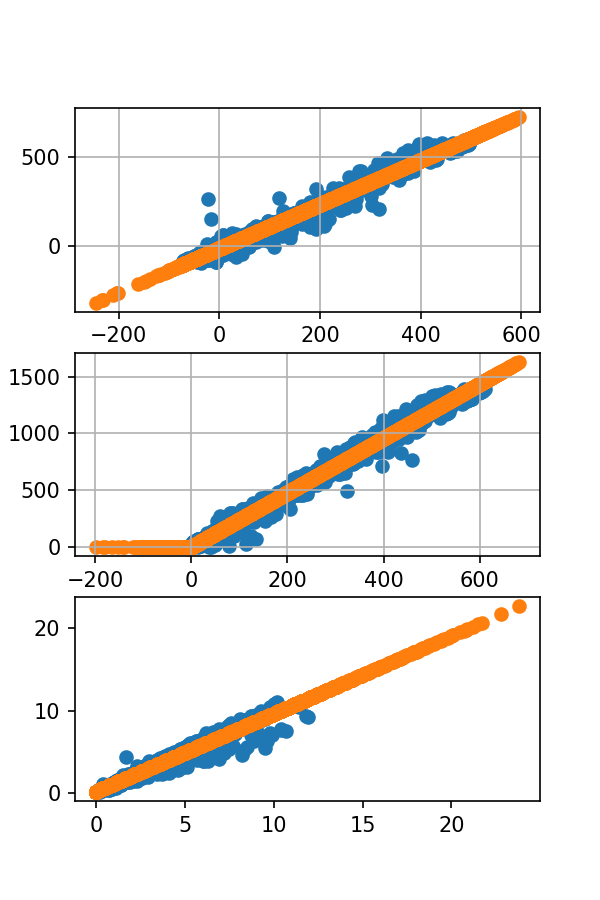

,X,r2,b,m,RMSE
y,,,,,
AirTC_Avg,Air_Temp,0.988,0.023,0.990,0.538
NR_Wm2_Avg,Net_RN,0.978,-14.843,1.243,25.705
PPFD_Avg,Net_SW,0.990,0.000,2.392,38.834
wind_speed,Wind_Speed,0.941,0.224,0.939,0.422
Rain_mm_Tot,Rainfall,0.988,-0.001,0.905,0.036


In [8]:
Data['const'] = 1

Sry = {
    'y':[],
    'X':[],
    'r2':[],
    'b':[],
    'm':[],
    'RMSE':[]
}

EC = ['AirTC_Avg','NR_Wm2_Avg','PPFD_Avg','wind_speed','Rain_mm_Tot']
AW =['Air_Temp','Net_RN','Net_SW','Wind_Speed','Rainfall','SW_Flag']

for y,x in zip(EC,AW):
    Sry['X'].append(x)
    X = [x]
    if y == 'wind_speed':
        DNA = Data.loc[Data['Rain_mm_Tot']==0,[y]+X].dropna()
    else:
        DNA=Data.loc[Data['Active_Layer_1'].isnull()==False,[y]+X].dropna()
    Sry['y'].append(y)
    if y != 'PPFD_Avg':# and y != 'wind_speed':
        X2 = sm.add_constant(DNA[X], has_constant='add')
        est = sm.OLS(DNA[y], X2)
        est = est.fit()    
#         Sry['r2'].append(est.rsquared_adj)
        Sry['b'].append(est.params['const'])
        Sry['m'].append(est.params[x])
        DNA['P'] = est.predict(X2)

    else:
#                 X2 = sm.add_constant(DNA[X], has_constant='add')
        est = sm.OLS(DNA[y], DNA[X])
        est = est.fit()    
#         Sry['r2'].append(est.rsquared_adj)
        Sry['b'].append(0)
        Sry['m'].append(est.params[x])
        DNA['P'] = est.predict(DNA[X])
    
    
    Sry['r2'].append(metrics.r2_score(DNA[y],DNA['P']))
    Sry['RMSE'].append(metrics.mean_squared_error(DNA[y],DNA['P'])**.5)
    
    if y == 'NR_Wm2_Avg' or y == 'PPFD_Avg' or y == 'wind_speed' or y == 'wind_speed':
        print(y)
        print('Scale')
        print(y+'_AWS_Scaled')
        if y != 'PPFD_Avg':# and y != 'wind_speed':
            Data[y+'_AWS_Scaled'] = est.predict(Data[['const']+X])
        else:
            Data[y+'_AWS_Scaled'] = est.predict(Data[X])


print(Data.loc[Data['PPFD_Avg_AWS_Scaled']<0,'Net_SW'].max())
        
Data.loc[Data['PPFD_Avg_AWS_Scaled']<Data['PPFD_Avg'].min(),'PPFD_Avg_AWS_Scaled']=Data['PPFD_Avg'].min()    


fig,ax = plt.subplots(3,figsize=(4,6))
ax[0].scatter(Data['Net_RN'],Data['NR_Wm2_Avg'])
ax[0].scatter(Data['Net_RN'],Data['NR_Wm2_Avg_AWS_Scaled'])
ax[0].grid()

ax[1].scatter(Data['Net_SW'],Data['PPFD_Avg'])
ax[1].scatter(Data['Net_SW'],Data['PPFD_Avg_AWS_Scaled'])
ax[1].grid()

ax[2].scatter(Data['Wind_Speed'],Data['wind_speed'])
ax[2].scatter(Data['Wind_Speed'],Data['wind_speed_AWS_Scaled'])

# Sry
Summary = pd.DataFrame(Sry)
Summary = Summary.set_index('y')
Summary.round(3)

## Temperature

0.987073325326995
0.5469583537919759


<IPython.core.display.Javascript object>


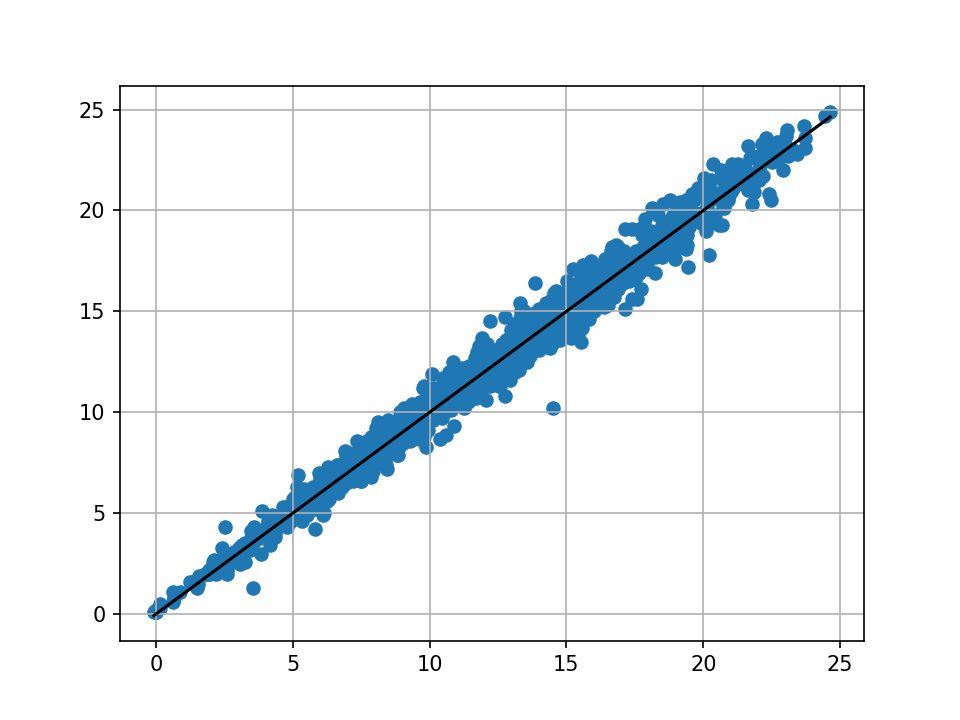

-0.08586944444444447


In [9]:
a,b='AirTC_Avg','Air_Temp'
DNA = Data[[a,b]].dropna()
print(metrics.r2_score(DNA[a],DNA[b]))
print(metrics.mean_squared_error(DNA[a],DNA[b])**.5)

plt.figure()
plt.scatter(DNA[a],DNA[b])
plt.plot([DNA[a].min(),DNA[a].max()],[DNA[a].min(),DNA[a].max()],color='k')
plt.grid()

print((DNA[a]-DNA[b]).mean())

Air_Temp
Scale
Air_Temp_ERA5_Scaled
                            OLS Regression Results                            
Dep. Variable:               Air_Temp   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                 3.006e+06
Date:                Mon, 18 Apr 2022   Prob (F-statistic):               0.00
Time:                        21:02:28   Log-Likelihood:            -2.5395e+05
No. Observations:              104761   AIC:                         5.079e+05
Df Residuals:                  104759   BIC:                         5.079e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const   

<IPython.core.display.Javascript object>


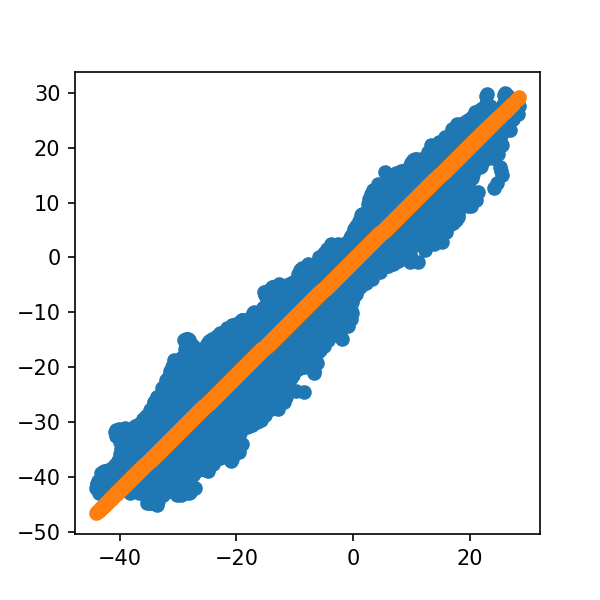

29.0
6.0
17.0
39.0
22.0


,X,m,b,r2,RMSE
y,,,,,
AirTC_Avg,temperature_2m,1.01,0.46,0.91,1.42
Air_Temp,temperature_2m,1.05,-0.52,0.97,2.73
Tdew,dewpoint_temperature_2m,0.88,35.55,0.84,1.17
Temp_5_2,soil_temperature_level_1,0.56,1.71,0.75,1.67
Temp_5_1,soil_temperature_level_2,0.62,-0.51,0.67,1.37
Temp_15_1,soil_temperature_level_3,0.48,-0.38,0.31,1.20
Temp_15_2,soil_temperature_level_3,0.50,-0.43,0.36,1.15
Table_1,volumetric_soil_water_layer_1,0.32,-0.20,0.81,0.01
Table_1,volumetric_soil_water_layer_2,0.70,-0.33,0.85,0.01


In [10]:
InSitu = ['AirTC_Avg','Air_Temp','Tdew',#'Rainfall',
#           'wind_speed',#'Wind_Speed',#,'H','NR_Wm2_Avg',
          'Temp_5_2','Temp_5_1','Temp_15_1','Temp_15_2',
          'Table_1','Table_1',
            'Net_SW','PPFD_Avg'
         ]
ERA5 = ['temperature_2m','temperature_2m','dewpoint_temperature_2m',
#         'Wind_10m',#'Wind_10m',#,'HH','RN',
        'soil_temperature_level_1','soil_temperature_level_2','soil_temperature_level_3','soil_temperature_level_3',
        'volumetric_soil_water_layer_1',
        'volumetric_soil_water_layer_2',
        'SW','DSW'
       ]

Sry = {
    'y':[],
    'X':[],
    'm':[],
    'b':[],
    'r2':[],
    'RMSE':[],
}

for y,x in zip(InSitu,ERA5):
    Sry['X'].append(x)
    X = [x]
    DNA=Data[[y]+X].dropna()
    Sry['y'].append(y)
    X2 = sm.add_constant(DNA[X], has_constant='add')
    est = sm.OLS(DNA[y], X2)
    est = est.fit()    
    Sry['r2'].append(est.rsquared_adj)
    Sry['b'].append(est.params['const'])
    Sry['m'].append(est.params[x])
    
    
    DNA['P'] = est.predict(X2)
    Sry['RMSE'].append(metrics.mean_squared_error(DNA[y],DNA['P'])**.5)
    
    if y == 'Air_Temp' or y == 'wind_speed' or y == 'Tdew':
        
        print(y)
        print('Scale')
        print(y+'_ERA5_Scaled')
        print(est.summary())
        Data[y+'_ERA5_Scaled'] = est.predict(Data[['const']+X])

    
fig,ax = plt.subplots(figsize=(4,4))
ax.scatter(Data['temperature_2m'],Data['Air_Temp'])
ax.scatter(Data['temperature_2m'],Data['Air_Temp_ERA5_Scaled'])
    
    
Data['Air_Temp_K']=Data['Air_Temp']+ 273.15
Data['AirTC_K']=Data['AirTC_Avg']+ 273.15
for m in [6,7,8,9]:
    print((Data.loc[((Data.index.month==m)&
                (Data['Tdew_ERA5_Scaled']>Data['Air_Temp_K'])),
               'Air_Temp_K'].count()/Data.loc[((Data.index.month==m)),'Air_Temp_K'].count()*100).round(0))

print((Data.loc[((Data.index.month>=6)&(Data.index.month<=9)&
            (Data['Tdew_ERA5_Scaled']>Data['Air_Temp_K'])),
           'Air_Temp_K'].count()/Data.loc[((Data.index.month>=6)&(Data.index.month<=9)),'Air_Temp_K'].count()*100).round(0))
Data.loc[Data['Tdew_ERA5_Scaled']>Data['Air_Temp_K'],'Tdew_ERA5_Scaled'] = Data.loc[Data['Tdew_ERA5_Scaled']>Data['Air_Temp_K'],'Air_Temp_K']
    

Summary = pd.DataFrame(Sry)
Summary = Summary.set_index('y')
Summary.round(2)



In [11]:
InSitu = ['Temp_5_1','Temp_5_2','Temp_15_1','Temp_15_2',
          'Table_1']
ERA5 = ['soil_temperature_level_1','soil_temperature_level_2','soil_temperature_level_3',
        'volumetric_soil_water_layer_1',
        'volumetric_soil_water_layer_2',
       ]

(Data[InSitu+ERA5].corr()[InSitu][5:]).round(2)#*np.sign(Data[InSitu+ERA5].corr()[InSitu][5:])

# print(Data.loc[Data['Wind_Speed']<.25,['Wind_Speed','wind_speed']].describe())

,Temp_5_1,Temp_5_2,Temp_15_1,Temp_15_2,Table_1
soil_temperature_level_1,0.65,0.86,-0.15,-0.11,-0.66
soil_temperature_level_2,0.82,0.75,0.29,0.30,-0.85
soil_temperature_level_3,0.56,0.36,0.56,0.60,-0.53
volumetric_soil_water_layer_1,-0.47,-0.48,0.08,0.08,0.90
volumetric_soil_water_layer_2,-0.52,-0.51,-0.01,0.00,0.92


# OLS vs Exp u*

In [12]:
print('u*')
# EC_Data['H']
# X = ['wind_speed','NR_Wm2_Avg']
X = ['wind_speed']
y = 'u*'
DNA = EC_Data.loc[EC_Data['Rain_mm_Tot']==0,X+[y]].dropna()

X2 = sm.add_constant(DNA[X], has_constant='add')
est = sm.OLS(DNA[y], X2)
est = est.fit()
print(est.summary())
print()
print(np.round(metrics.mean_squared_error(DNA[y],est.predict(X2))**.5,4))
# X = ['wind_speed_AWS_Scaled','NR_Wm2_Avg_AWS_Scaled']
X = ['wind_speed_AWS_Scaled']
Data['u*_OLS'] = est.predict(Data[['const']+X])

print()
print('Vals')

a,b='u*','u*_OLS'
DNA = Data[[a,b]].dropna()

print(np.round(metrics.r2_score(DNA[a],DNA[b]),4))
print(np.round(metrics.mean_squared_error(DNA[a],DNA[b])**.5,4))
print()

print()


Temp = EC_Data[['PPFD_Avg']].resample('5T').asfreq()
D = Temp.index.floor('D').to_julian_date()
T = Temp.index.hour/24+Temp.index.minute/60/24
A = np.ones(D.shape[0])

Zenith,Angle,Angle_Corr,Azimuth,Sunrise,Sunset=SS.SunStats(LAT*A,LON*A,D.values,T.values,TZ*A)
Temp['Sun_Angle'] = Angle_Corr
Temp = Temp.resample('30T').mean()

try:
    EC_Data = EC_Data.drop(columns=['Sun_Angle'])
except:
    pass
EC_Data = EC_Data.join(Temp[['Sun_Angle']])

EC_Data['Daytime']=0
EC_Data.loc[EC_Data['Sun_Angle']>-0.5,'Daytime']=1


print(Data['wind_speed_AWS_Scaled'].describe())

u*
                            OLS Regression Results                            
Dep. Variable:                     u*   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 4.245e+04
Date:                Mon, 18 Apr 2022   Prob (F-statistic):               0.00
Time:                        21:02:28   Log-Likelihood:                 6565.4
No. Observations:                3625   AIC:                        -1.313e+04
Df Residuals:                    3623   BIC:                        -1.311e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0108      0.002      6.953      

C:\Users\User\FishIsland_Flux_Analysis\FluxProcessing\SunStatistics.py:25: RuntimeWarning: invalid value encountered in arccos
  W2 = np.degrees(np.arccos(np.cos(np.radians(90.833))/(np.cos(np.radians(LAT))*np.cos(np.radians(T2)))-np.tan(np.radians(LAT))*np.tan(np.radians(T2)))) #HA Sunrise (deg)


In [13]:
def Q10 (T,R10,Q10):
#     ER =  
    return(R10*Q10**(T-10/10))

def LogCurve (T,r1,r2,r3):
    
    return(1/(r1*r2**(T) + r3))

def line(x, a, b):
    return a * (x)+b

def u_curve(x, a, b,c):
    return a * (x)**b+c

def u_curve2(X, a, b, c ):
    x = X[:,0]
    y = X[:,1]
    return (a * (x)**b)+(c*y)#*x


def KFC(X,y,AllData,Pred_Data,Alt_X,curve,K=30,random_state=1,Verbose = True,CI=False):
    Data = AllData[X+y].dropna()
    kf = KFold(n_splits=K,shuffle=True, random_state = random_state)
    R2 = []
    MSE = []
    Int = []
    Coef = []
    Pred = []
    for train_index, test_index in kf.split(Data):
        df_test = Data.iloc[test_index]
        df_train = Data.iloc[train_index]
        X_train = np.array(df_train[X])#.reshape(-1, 1)     
        y_train = np.array(df_train[y]).flatten()#(-1, 1)
        X_test = np.array(df_test[X])#.reshape(-1, 1)  
        y_test = np.array(df_test[y]).flatten()#(-1, 1)
        if X_train.shape[1]==1:
            X_train = X_train.flatten()
            X_test = X_test.flatten()
        popt, pcov = curve_fit(curve, X_train,y_train)
        Test = curve(X_test, *popt)
        R2.append(metrics.r2_score(y_test,Test))
        MSE.append(metrics.mean_squared_error(y_test,Test))
        Pred.append(curve(Pred_Data[Alt_X].values, *popt))
        Coef.append([*popt])
    Coef_min = np.min(np.array(Coef),axis=0)
    Coef_max = np.max(np.array(Coef),axis=0)
    Coef_std = np.std(np.array(Coef),axis=0)
    Coef = np.mean(np.array(Coef),axis=0)
    if Verbose == True:
        print()
        print(y[0])
        print('RMSE', np.round(np.mean(np.array(MSE)**.5),5))
        print('std RMSE', np.round(np.std(np.array(MSE)**.5),5))
        print('r2', np.round(np.median(np.array(R2)),5))
        print('Coef', Coef)
#         print('Coef_min', Coef_min)
#         print('Coef_max', Coef_max)
        print('Coef_CI', (Coef_std/K**.5)*stats.t.ppf(0.975,K))
        for a,k in zip(Coef,['a','b','c','d']):
            print(k,' {:4f}'.format(a))
    if CI == True:
        return(np.nanmean(np.array(Pred),axis=0),
               (np.nanstd(np.array(Pred),axis=0)/K**.5)*stats.t.ppf(0.975,K))
    else:
        return(np.nanmean(np.array(Pred),axis=0))


In [14]:
Temp = Data.loc[((Data['Daytime']==0)&(Data['PPFD_Avg']<10)),['fco2','Temp_5_1','Temp_15_1','Temp_5_2','AirTC_Avg','PPFD_Avg']].dropna()
# print(Temp.shape)
y = ['fco2']
X = ['AirTC_Avg']
Alt_X=['AirTC_Avg']
Temp['ER'] = KFC(X,y,Temp,Temp,Alt_X,Q10,K=30)


y = ['fco2']
X = ['Temp_5_1']
Alt_X=['Temp_5_1']
ER,CI = KFC(X,y,Temp,Temp,Alt_X,Q10,K=30,CI=True)


Temp['ER'] = ER
Temp['ER_CI'] = CI

print(Temp[['ER','ER_CI']].describe())
# y = ['fco2']
# X = ['Temp_5_1']
# Alt_X=['Temp_5_1']
# Temp['ER'] = KFC(X,y,Temp,Temp,Alt_X,LogCurve,K=30)


fco2
RMSE 0.22616
std RMSE 0.09638
r2 0.23268
Coef [0.47363603 1.09563689]
Coef_CI [0.00317588 0.000847  ]
a  0.473636
b  1.095637

fco2
RMSE 0.2032
std RMSE 0.09694
r2 0.4151
Coef [0.46151047 1.14126111]
Coef_CI [0.0028458  0.00119797]
a  0.461510
b  1.141261
               ER       ER_CI
count  110.000000  110.000000
mean     0.980695    0.002164
std      0.227327    0.000924
min      0.599630    0.001405
25%      0.801543    0.001543
50%      0.957981    0.001845
75%      1.146457    0.002459
max      1.560340    0.006107


In [15]:

Dark = EC_Data.loc[((EC_Data['Daytime']<=0)&
                   (EC_Data['PPFD_Avg']<10)),
                   ['fco2','Temp_2_5_1','Temp_2_5_2','Temp_5_1','Temp_15_1','Temp_5_2','AirTC_Avg','PPFD_Avg']].dropna()#.describe()

y = ['fco2']
X = ['AirTC_Avg']
Alt_X=['AirTC_Avg']
Dark['ER'] = KFC(X,y,Dark,Dark,Alt_X,Q10,K=10)


y = ['fco2']
X = ['Temp_5_2']
Alt_X=['Temp_5_2']
Dark['ER'] = KFC(X,y,Dark,Dark,Alt_X,Q10,K=10)


y = ['fco2']
X = ['Temp_5_1']
Alt_X=['Temp_5_1']
Dark['ER'] = KFC(X,y,Dark,Dark,Alt_X,LogCurve,K=10)

y = ['fco2']
X = ['Temp_2_5_2']
Alt_X=['Temp_2_5_2']
Dark['ER'] = KFC(X,y,Dark,Dark,Alt_X,LogCurve,K=10)



fco2
RMSE 0.28199
std RMSE 0.05709
r2 0.31014
Coef [0.51367191 1.08163639]
Coef_CI [0.01143714 0.002679  ]
a  0.513672
b  1.081636

fco2
RMSE 0.27805
std RMSE 0.0574
r2 0.32723
Coef [0.50654775 1.10092486]
Coef_CI [0.01264011 0.00387561]
a  0.506548
b  1.100925

fco2
RMSE 0.27053
std RMSE 0.05117
r2 0.39634
Coef [2.75651068 0.77042236 0.53925552]
Coef_CI [0.09871921 0.01348955 0.04268296]
a  2.756511
b  0.770422
c  0.539256

fco2
RMSE 0.26078
std RMSE 0.06545
r2 0.46855
Coef [2.35193306 0.87463359 0.18105747]
Coef_CI [0.15516702 0.01562447 0.1945756 ]
a  2.351933
b  0.874634
c  0.181057


In [16]:


y =['u*']
X = ['wind_speed']
Alt_X = ['wind_speed_AWS_Scaled']
Data['u*_OLS'] = KFC(X,y,EC_Data,Data,Alt_X,line,K=30)


y =['u*']
X = ['wind_speed']
Alt_X = ['wind_speed_AWS_Scaled']
Data['u*_curve'] = KFC(X,y,EC_Data,Data,Alt_X,u_curve,K=30)

print()
X = ['wind_speed','NR_Wm2_Avg']
Alt_X = ['wind_speed_AWS_Scaled','NR_Wm2_Avg_AWS_Scaled']
Data['u*_curve2'] = KFC(X,y,EC_Data,Data,Alt_X,u_curve2,K=30)




u*
RMSE 0.04093
std RMSE 0.003
r2 0.91761
Coef [0.07639449 0.01074994]
Coef_CI [3.11961493e-05 1.30940013e-04]
a  0.076394
b  0.010750


<ipython-input-13-7f36923496cc>:65: RuntimeWarning: Mean of empty slice
  return(np.nanmean(np.array(Pred),axis=0))



u*
RMSE 0.04064
std RMSE 0.00326
r2 0.91747
Coef [ 0.09859291  0.8946883  -0.02098539]
Coef_CI [0.00032835 0.00137285 0.00047221]
a  0.098593
b  0.894688
c  -0.020985



<ipython-input-13-7f36923496cc>:65: RuntimeWarning: Mean of empty slice
  return(np.nanmean(np.array(Pred),axis=0))



u*
RMSE 0.03944
std RMSE 0.00371
r2 0.92474
Coef [8.23654178e-02 9.58542046e-01 5.97674105e-05]
Coef_CI [4.41667069e-05 3.57166411e-04 3.04084101e-07]
a  0.082365
b  0.958542
c  0.000060


<ipython-input-13-7f36923496cc>:65: RuntimeWarning: Mean of empty slice
  return(np.nanmean(np.array(Pred),axis=0))


# RF VPD

In [17]:
#
print('VPD')
Temp = Data[['VPD','Air_Temp','dewpoint_temperature_2m']].dropna()

print('Data')
Mod = RandomForestRegressor(min_samples_split=2, random_state=69)
Mod.fit(Temp[['Air_Temp','dewpoint_temperature_2m']], Temp['VPD'])
Mod.score(Temp[['Air_Temp','dewpoint_temperature_2m']], Temp['VPD'])
Data.loc[~Data[['Air_Temp','dewpoint_temperature_2m']].T.isnull().any(),
         'VPD_RF'] = Mod.predict(Data.loc[~Data[['Air_Temp','dewpoint_temperature_2m'
                            ]].T.isnull().any(),['Air_Temp','dewpoint_temperature_2m']])

Data.loc[~Data[['Air_Temp','dewpoint_temperature_2m']].T.isnull().any(),
         'VPD_RF_ecmwf'] = Mod.predict(Data.loc[~Data[['Air_Temp','dewpoint_temperature_2m'
                            ]].T.isnull().any(),['Air_Temp','dewpoint_temperature_2m']])

a,b='VPD','VPD_RF'
DNA = Data[[a,b]].dropna()

print(metrics.r2_score(DNA[a],DNA[b]))
print(metrics.mean_squared_error(DNA[a],DNA[b])**.5)
print(Mod.feature_importances_)

VPD
Data
0.9854006474900388
45.8835765586663
[0.84459244 0.15540756]


In [18]:
a,b='Tdew','dewpoint_temperature_2m'

S = Data.loc[((Data['Wind_Direction']>135)&
          (Data['Wind_Direction']<235)),
         ['Tdew','dewpoint_temperature_2m']].dropna()

print(metrics.r2_score(S[a],S[b]))
print(metrics.mean_squared_error(S[a],S[b])**.5)
print((S[a]-S[b]).mean())
print()

N = Data.loc[((Data['Wind_Direction']<45)|
          (Data['Wind_Direction']>315)),
         ['Tdew','dewpoint_temperature_2m']].dropna()

print(metrics.r2_score(N[a],N[b]))
print(metrics.mean_squared_error(N[a],N[b])**.5)
print((N[a]-N[b]).mean())

0.8285785942655615
1.2555393651987774
0.5875760547378607

0.5330166576059362
2.030360102024752
1.6755097564589467


In [19]:
# print(Data['Wind_Direction'].describe())

# Data['Wind_Direction']=Data['Wind_Direction'].fillna(-1)
# Data['D_bins'] = pd.cut(Data['Wind_Direction'],[-2,0,45,90,135,180,225,270,315,360])

# for d in Data['D_bins'].unique():
#     a,b='Tdew','dewpoint_temperature_2m'
#     DNA = Data.loc[Data['D_bins']==d,[a,b]].dropna()
#     try:
#         print()
#         print(d)
#         print(metrics.r2_score(DNA[a],DNA[b]))
#         print(metrics.mean_squared_error(DNA[a],DNA[b])**.5)
#         print()
#         y = ['Tdew']
#         X = ['dewpoint_temperature_2m','Air_Temp','temperature_2m']#,'Net_RN'
#         # X = ['dewpoint_temperature_2m','U_bar_AWS','V_bar_AWS','Air_Temp','Net_RN']

#         K = 30
#         Temp = Data.loc[Data['D_bins']==d].copy()
#         Val,C,I,MSE,R2 = Model_Test(X,y,Temp.loc[~Temp[X].T.isnull().any()],K=K,
#                                      Test = 'OLS',Scale=True,Task='Predict_Return',Verbose=True)
# #         print(R2)

        
#     except:
#         pass
# #     print(Data.loc[Data['D_bins']==d,[]].corr()['Tdew'][1]**2)

# Data['D_bins'].unique()

In [20]:
y = ['Tdew']

# Data['T_Diff'] = Data['Air_Temp'] - Data['temperature_2m']

X = ['dewpoint_temperature_2m','temperature_2m','Air_Temp','Net_SW','Net_LW','V_bar_AWS','U_bar_AWS']
Factors = ['ERA5 $T_{dew}$','ERA5 $T_a$','AWS $T_a$','AWS SW','AWS LW','AWS v','AWS u']
# X = ['dewpoint_temperature_2m','U_bar_AWS','V_bar_AWS','Air_Temp','Net_RN']

K = 30
Val,Coef,I,MSE,R2 = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],K=K,
                             Test = 'OLS',Scale=True,Task='Predict_Return',Verbose=True)

print()
print(np.round(np.abs(Coef)/(np.abs(Coef)).sum(),3))

Data[y[0]+'_OLS']=np.nan
Data.loc[~Data[X].T.isnull().any(),y[0]+'_OLS']=Val

print()
print()
print(Data.loc[((Data.index.month>=6)&(Data.index.month<=9)&(Data['Tdew_OLS']>Data['Air_Temp_K'])),'Air_Temp_K'
        ].count()/Data.loc[((Data.index.month>=6)&(Data.index.month<=9)),'Air_Temp_K'].count())
print()

for m in [6,7,8,9]:
    pct =Data.loc[((Data.index.month==m)&(Data['Tdew_OLS']>Data['Air_Temp_K'])),'Air_Temp_K'
        ].count()/Data.loc[((Data.index.month==m)),'Air_Temp_K'].count()
    print(pct)
    
Data.loc[Data['Tdew_OLS']>Data['Air_Temp_K'],'Tdew_OLS'] = Data.loc[Data['Tdew_OLS']>Data['Air_Temp_K'],'Air_Temp_K']

# plt.figure()
# plt.barh(XL[::-1],C[::-1])


Tdew
RMSE 1.0329389506967293
std RMSE 0.05292387665535789
r2 0.8758009690589992
coef [ 2.50858325 -0.97026533  1.54532512 -0.35730876  0.20081491 -0.33203957
 -0.01716293]
int 281.6139351117647

[0.423 0.164 0.261 0.06  0.034 0.056 0.003]


0.16532258064516128

0.19652777777777777
0.04660303200449186
0.13239601640304627
0.28900462962962964


TA
0.8890712534021784
1.5199714751377944
-0.5279446472155873
TA
0.8724592370319447
1.629813422475874
-0.6138140916600311


<IPython.core.display.Javascript object>


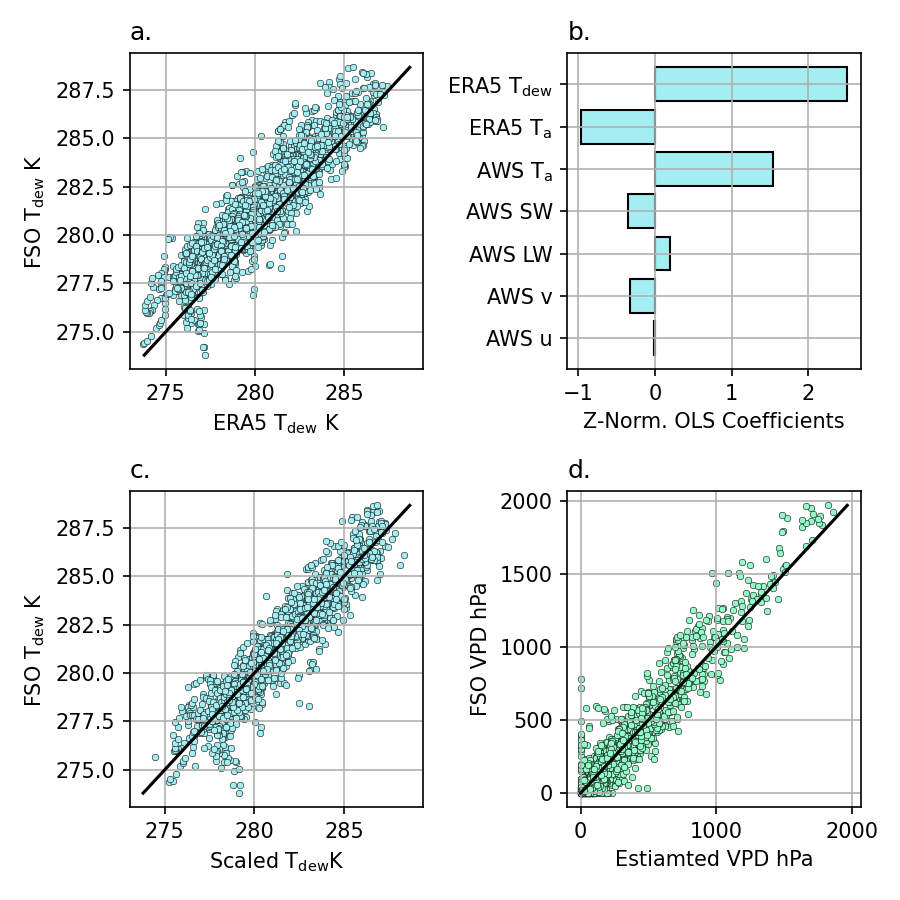

dewpoint_temperature_2m
0.709306306671654
1.6625043495275584

Tdew_OLS
0.8655949839479966
1.0100545612136658

VPD_ERA5
0.8859889950217179
116.27958924198515

0.0


In [21]:
def getES(temp,unit = 'K'):
    temp = temp.copy()
    if temp.mean()<100:
        temp += 273.15
    es = 6.11 * np.exp((2.453e6 / 461) * (1 / 273.15 - 1 / (temp)))
    return(es)
def getVPD(Tdew,Temp):
    e = getES(Temp)
    es = getES(Tdew)
    vpd = e-es
    return(vpd*100)
a,b='temperature_2m','AirTC_Avg'
DNA = Data[[a,b]].dropna()

# fig,ax=plt.subplots(2,figsize=(3,6))
r2=(metrics.r2_score(DNA[a],DNA[b]))
rmse = (metrics.mean_squared_error(DNA[a],DNA[b])**.5)
print('TA')
print(r2)
print(rmse)
MBE = (DNA[a]-DNA[b]).mean()
print(MBE)

a,b='temperature_2m','Air_Temp'
DNA = Data[[a,b,'AirTC_Avg']].dropna()

r2=(metrics.r2_score(DNA[a],DNA[b]))
rmse = (metrics.mean_squared_error(DNA[a],DNA[b])**.5)
print('TA')
print(r2)
print(rmse)
MBE = (DNA[a]-DNA[b]).mean()
print(MBE)
Data['RH_ERA5'] = getES(Data['dewpoint_temperature_2m'])/getES(Data['temperature_2m'])*100

Data['VPD_ERA5'] = getVPD(Data['Tdew_OLS'],Data['Air_Temp_K'])

A = ['dewpoint_temperature_2m','Tdew_OLS',
     'VPD_ERA5']
B = ['Tdew','Tdew','VPD']
T = ['a.','c.','d.']
fig,((ax1,ax3),(ax2,ax4))=plt.subplots(2,2,figsize=(6,6))
axes = [ax1,ax2,ax4]
C = ['#a2eef2','#a2eef2','#93fac8']
XL = ['ERA5 $T_{dew}$ K','Scaled $T_{dew} K$','Estiamted VPD hPa']
YL = ['FSO $T_{dew}$ K','FSO $T_{dew}$ K','FSO VPD hPa']
for a,b,ax,t,xl,yl,c in zip(A,B,axes,T,XL,YL,C):
    DNA = Data[[a,b,'Air_Temp_K']].dropna()
    if a == 'VPD_(ERA5_TDew)_(AWS_TA)':
        DNA.loc[DNA[a]<0,a]=0
    if a == 'VPD_(ERA5_TDew_Scaled)_(AWS_TA)':
        DNA.loc[DNA[a]<0,a]=0

    MBE = (DNA[a]-DNA[b]).mean()
#     print(MBE)
    r2=(metrics.r2_score(DNA[a],DNA[b]))
    rmse=(metrics.mean_squared_error(DNA[a],DNA[b])**.5)
    ax.scatter(DNA[a],DNA[b],s=10,edgecolor='k',linewidth=.25,color=c,
              )
    ax.grid()
#     if t == 'a.':
#         ax.set_ylabel(('EC Station Ta'))
#     else:
    ax.set_ylabel(yl)
    ax.plot([DNA[b].min(),DNA[b].max()],[DNA[b].min(),DNA[b].max()],color='k')
    
    ax.set_xlabel(xl)
    ax.set_title(t,#+' r2 = '+str(np.round(r2,2))+' rmse = '+str(np.round(rmse,2)),
                 loc='left')
    print(a)
    print(r2)
    print(rmse)
    print()
    
    

ax3.barh(Factors[::-1],Coef[::-1],edgecolor='k',color='#a2eef2')
ax3.grid()
ax3.set_title('b.',loc='left')
ax3.set_xlabel('Z-Norm. OLS Coefficients')
    
plt.tight_layout()
plt.savefig(G_Drive+'PhD_Thesis\\Chapter3_Figs/VPD_est.png',dpi=600)


SubZ = Data.loc[((Data.index.dayofyear>=174)&(Data.index.dayofyear<=256)&(Data['VPD_ERA5']<0))].shape[0]
PlusZ = Data.loc[((Data.index.dayofyear>=174)&(Data.index.dayofyear<=256)&(Data['VPD_ERA5']>=0))].shape[0]
print(SubZ/PlusZ)


# Daily

* Temperature Fill
* NDIS Fill

# Snowmelt

In [22]:
Y = 'Temp'

Daily = Data.resample('D').mean()
Daily[['NDVI_FI_LCP','NDSI_FI_LCP','NDWI_FI_LCP']]=Daily[['NDVI_FI_LCP','NDSI_FI_LCP','NDWI_FI_LCP']].interpolate()

Daily['MM-DD']=Data.resample('D').first()['MM-DD']
Daily['T_max'] = Data.resample('D').max()['Air_Temp']
Daily['T_min'] = Data.resample('D').min()['Air_Temp']
Daily['Date'] = Daily.index.date
Daily[['Rainfall','total_precipitation_hourly']] = Data.resample('D').sum()[['Rainfall','total_precipitation_hourly']]

X = ['NDSI_FI_LCP']       
y = 'snow_cover'
# Y = 'AL_data_est'
DNA = Daily.loc[((Daily.index.month>=4)|(Daily.index.month<=10))][X+[y]].dropna()

X2 = sm.add_constant(DNA[X], has_constant='add')
est = sm.OLS(DNA[y], X2)
est = est.fit()

print(est.summary())
# DNA


# print(Flood)

                            OLS Regression Results                            
Dep. Variable:             snow_cover   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                 3.482e+04
Date:                Mon, 18 Apr 2022   Prob (F-statistic):               0.00
Time:                        21:02:37   Log-Likelihood:                -33205.
No. Observations:                7575   AIC:                         6.641e+04
Df Residuals:                    7573   BIC:                         6.643e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          36.7680      0.255    144.221      

In [23]:

Flood = Daily.loc[(((Daily.index.month==5)&(Daily.index.day>10))|((Daily.index.month==6)&(Daily.index.day<20)))].copy()

X = 'NDWI_FI_LCP' 
y = 'KULUARPAK'
DNA = Flood[[X,y]].dropna()

X2 = sm.add_constant(DNA[X], has_constant='add')
est = sm.OLS(DNA[y], X2)
est = est.fit()

print(est.summary())

# plt.figure()
# plt.scatter(DNA[X],DNA[y])

                            OLS Regression Results                            
Dep. Variable:              KULUARPAK   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     1212.
Date:                Mon, 18 Apr 2022   Prob (F-statistic):          5.38e-120
Time:                        21:02:37   Log-Likelihood:                 90.685
No. Observations:                 380   AIC:                            -177.4
Df Residuals:                     378   BIC:                            -169.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.6411      0.011    853.983      

In [24]:
Classes = { 'Snow Pack':100,
      'Significant':95,
#       'Partial':60,
      'Patchy':18.75,
      'Snow Free':0.04}

Values = {'Snow Pack':0,#1/8,
          'Significant':1/4,
          'Patchy':3/8,
          'Snow Free':1/2}

Thresh = 0.5
Daily['Warm']=0
Daily['Flood']=0

Daily['Air_Temp_fill'] = Daily['Air_Temp'].fillna(Daily['Air_Temp_ERA5_Scaled'])
Data['Air_Temp_fill'] = Data['Air_Temp'].fillna(Data['Air_Temp_ERA5_Scaled'])

for c,v in Classes.items():
    Daily.loc[((Daily['snow_cover']<=v)),'Snow_Class']=c
    Daily.loc[((Daily['snow_cover']<=v)&(Daily['Air_Temp_fill']>Thresh)),'Warm']=Values[c]
    Daily.loc[((Daily['NDWI_FI_LCP']>0.01)
              |(Daily.index.month<5)),'Flood']=1
        
Daily['Flood_Class'] = 'Not Flooded'
Daily.loc[(((Daily.index.month==5)|((Daily.index.month==6)))&(Daily['NDWI_FI_LCP']>0.0)),'Flood_Class']='Unlikely'
Daily.loc[(((Daily.index.month==5)|((Daily.index.month==6)))&(Daily['NDWI_FI_LCP']>0.1)),'Flood_Class']='Possible'
Daily.loc[(((Daily.index.month==5)|((Daily.index.month==6)))&(Daily['NDWI_FI_LCP']>0.15)),'Flood_Class']='Probable'
    
Daily['NDSI_Snow_Class'] = 'Snow'
Daily.loc[(Daily['NDSI_FI_LCP']<0.0),'NDSI_Snow_Class']='No Snow'
Daily.loc[Daily['NDSI_Snow_Class']!='No Snow','Warm']*=2
    
Daily['Thaw_Class'] = 'Freeze'
Daily.loc[(Daily['Air_Temp_fill']>Thresh),'Thaw_Class']='Thaw'
# Daily['Warm']=0
# Daily.loc[(Daily['Air_Temp_fill']>Thresh),'Warm']=1#'Thaw'
            
FDF = pd.DataFrame(data={})
FDF['Start'] = Daily.loc[((Daily['Snow_Class']=='Snow Free'))].resample('Y').first()['Date']
FDF['Start_doy'] = Daily.loc[((Daily['Snow_Class']=='Snow Free'))].resample('Y').first()['DOY']
FDF['Start_NDSI'] = Daily.loc[Daily['NDSI_FI_LCP']<=0].resample('Y').first()['Date']
FDF['End_Flood'] = Daily.loc[Daily['Flood_Class']=='Unlikely'].resample('Y').last()['Date']
FDF['End_Flood_doy'] = Daily.loc[Daily['Flood_Class']=='Unlikely'].resample('Y').last()['DOY']+1
FDF['Start_NDSI_doy'] = Daily.loc[((Daily['NDSI_FI_LCP']<=0)&(Daily.index.month>=5))].resample('Y').first()['DOY']
FDF['End'] = Daily.loc[((Daily.index.month>=9)&(Daily['Snow_Class']=='Significant'))].resample('Y').first()['Date']
FDF['End_doy'] = Daily.loc[((Daily.index.month>=9)&(Daily['Snow_Class']=='Significant'))].resample('Y').first()['DOY']
FDF.index=FDF.index.year

for y in range(2000,2021):
    Year = Daily.loc[Daily.index.year==y].copy()
    Year['Season_Sum'] = (Year['Warm']).cumsum()
    Daily.loc[Daily.index.year==y,'Season_Sum']=Year['Season_Sum']*1
    FDF.loc[FDF.index==y,'Season_Sum']=Year['Season_Sum'].max()
    
AL_obs = pd.read_csv(Output_Path+'AL_obs.csv',index_col=['Date'],parse_dates=['Date'])

AL_s = ['Reindeer Depot  (Thaw tube)','Lousy Point (Thaw tube)','Taglu (grid)']

ALH=pd.read_csv(Output_Path+'AL_Depth.csv',header=[1])
AL=pd.read_csv(Output_Path+'AL_Depth.csv',skiprows=4)
AL.columns=ALH.columns
AL=AL.rename(columns={'Name':'Year'})
AL = AL.set_index('Year')
AL[AL_s]/=100

AL = AL.loc[AL.index>=2000,AL_s]
T = Daily.loc[Daily.index.year>=2000].resample('Y').mean()[['Air_Temp_fill']]
T['Snow_Free_Days'] = Daily.loc[((Daily.index.year>=2000)&
                                 (Daily['Snow_Class']=='Snow Free'))].resample('Y').count()[['Air_Temp_fill']]
T['Snow_Free_Days_NDSI'] = Daily.loc[((Daily.index.year>=2000)&
                                 (Daily['NDSI_Snow_Class']=='No Snow'))].resample('Y').count()[['Air_Temp_fill']]
T['Thaw_Class'] = Daily.loc[((Daily.index.year>=2000)&
                                 (Daily['Thaw_Class']=='Thaw'))].resample('Y').count()[['Air_Temp_fill']]

for y in range(2008,2018):
    Fy=Flood.loc[(Flood.index.year==y)].copy()
#     print(Fy['BIG_LAKE'].max())
    FDF.loc[FDF.index==y,'NDWI_Peak']=Fy['NDWI_FI_LCP'].max()
    for s in ['KULUARPAK','BIG_LAKE']:
        if Fy[s].count()/(1464/24)>.5:
            if s == 'KULUARPAK':
                i = 0
            else:
                i = 1
            if s == 'KULUARPAK' and y == 2010:
                Fy.loc[((Fy.index.month==5)&(Fy.index.day<27)),s]=np.nan
            v=Fy[s].max()
            d = Fy.loc[((Fy[s]==v))].index.date
            doy = Fy.loc[((Fy[s]==v))].index.dayofyear
            FDF.loc[FDF.index==y,s+'_Peak']=v
            FDF.loc[FDF.index==y,s+'_Peak_Date']=d
            FDF.loc[FDF.index==y,s+'_Peak_doy']=doy

Daily['Study_Season']=0
for i,row in FDF.iterrows():
    Daily.loc[((Daily.index.date>row['End_Flood'])&
               (Daily['NDSI_Snow_Class']=='No Snow')
               &(Daily.index.date<=row['End'])),'Study_Season']=1
# Data['Study_Season']=

try:
    AL = AL.join(Data.groupby([Data.index.year,'Snow_Class']).count()['temperature_2m'].unstack())
    AL = AL.join(Data.groupby([Data.index.year,Data.index.month]).mean()['Air_Temp_fill'])
except:
    pass

# FA = 'End_Flood_doy'
FA = 'Start_NDSI_doy'

F0 = 'Start_doy'
F1 = 'BIG_LAKE_Peak_doy'
F2 = 'KULUARPAK_Peak_doy'
F3 = 'End_Flood_doy'
FS = [F0,F1,F2,F3]
for F in FS:
    DNA = FDF[[FA,F]].dropna()
#     DNA
    print(F)
#     print((DNA.corr(method='spearman')[F][0]).round(2))
    r,p = r_pvalues(DNA,method='spearman')
    print(r[F][0])
    print(p[F][0])    
    print(stats.mannwhitneyu(DNA[FA],DNA[F]))
    print((DNA[FA]-DNA[F]).describe())
    print()
    
T['Year']=T.index.year
T = T.set_index('Year')
AL = AL.join(T).join(FDF)
Cor = AL.corr(method='spearman')[AL_s]**2

# AL['Air_Temp_fill']

DNA = AL[AL_s[0:2]+['Air_Temp_fill','Snow_Free_Days','Snow_Free_Days_NDSI','Thaw_Class','Season_Sum']].dropna().astype(float)
# DNA
r,p = r_pvalues(DNA,method='spearman')#[AL_s]
r[p>0.05]=np.nan
r[r==1.0]=np.nan
r[AL_s[0:2]]
# print((r[v]**2).dropna().astype(float).round(2))


# Cor[Cor<.2]=np.nan
# Cor.round(2)

FDF
r,p=r_pvalues(Flood[['BIG_LAKE','KULUARPAK','NDWI_FI_LCP']],L=3)
print(r)
print(p)

Start_doy
0.662
0.001
MannwhitneyuResult(statistic=194.5, pvalue=0.25977681979712997)
count    21.000000
mean      1.761905
std       4.742412
min      -6.000000
25%      -1.000000
50%       2.000000
75%       5.000000
max      11.000000
dtype: float64

BIG_LAKE_Peak_doy
0.925
0.008
MannwhitneyuResult(statistic=15.5, pvalue=0.37287477462077356)
count    6.000000
mean     1.166667
std      2.316607
min     -2.000000
25%      0.250000
50%      1.000000
75%      1.750000
max      5.000000
dtype: float64

KULUARPAK_Peak_doy
0.817
0.007
MannwhitneyuResult(statistic=30.0, pvalue=0.18762307829634373)
count    9.000000
mean     3.000000
std      2.915476
min     -2.000000
25%      1.000000
50%      3.000000
75%      5.000000
max      7.000000
dtype: float64

End_Flood_doy
0.954
0.0
MannwhitneyuResult(statistic=171.5, pvalue=0.1101316805151813)
count    21.000000
mean      2.523810
std       3.487392
min       0.000000
25%       1.000000
50%       1.000000
75%       2.000000
max      15.000000


In [25]:
# (FDF[FA]-FDF[F3])#.describe()

# r,p=r_pvalues(FDF[['BIG_LAKE_Peak','BIG_LAKE_Peak_doy','KULUARPAK_Peak','KULUARPAK_Peak_doy',
#                    'End_Flood_doy','NDWI_Peak']],method = 'pearson',L=3)

# print(r)
# print(p)
# print(Data['fco2'].dropna())
# T = Daily.loc[((Daily.index.month==5)|(Daily.index.month==6))]

# (T["NDWI_FI_LCP"]-T["NDSI_FI_LCP"])#.describe()
# T[['NDWI_FI_LCP','NDSI_FI_LCP']].corr()
# (Pearson r = 0.98, p < 0.01)# Flood.scatter()

<IPython.core.display.Javascript object>


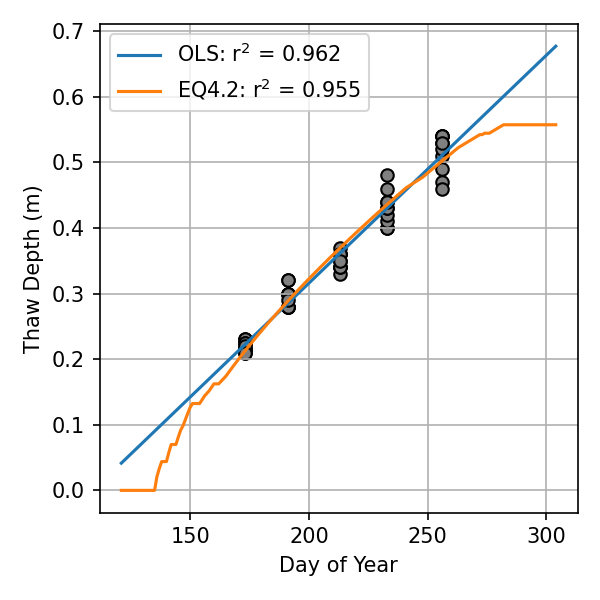

[ 0.00347288 -0.37871829]
[[ 9.85969226e-09 -2.10208640e-06]
 [-2.10208640e-06  4.56708839e-04]]
0.9622419963499104
0.020251239715776654

[0.03342453 0.67221708]
[[ 8.38535914e-06 -6.70367878e-05]
 [-6.70367878e-05  5.41088217e-04]]
0.9553149604057827
0.022030693881649455

Active_Layer_1
RMSE 0.02218
std RMSE 0.00362
r2 0.95073
Coef [0.03337055 0.67271527]
Coef_CI [0.00059292 0.00460714]
a  0.033371
b  0.672715

Reindeer Depot  (Thaw tube)    0.82
Lousy Point (Thaw tube)        0.90
Name: Active_Layer_1_fit, dtype: float64
Reindeer Depot  (Thaw tube)    0.69
Lousy Point (Thaw tube)        0.87
Name: Active_Layer_1_fit, dtype: float64


In [26]:
from scipy.optimize import curve_fit
def AL_curve(x, a, b):

    return a * (x)**b

def AL_line(x, a, b):

    return a * (x) + b


for v in ['DOY','Season_Sum']:
    for d in AL_obs.index.unique():
        AL_obs.loc[AL_obs.index==d,v]=Daily.loc[Daily.index.date==d,v].values[0]
        
        
y = 'Active_Layer_1'
fig,ax= plt.subplots(figsize=(4,4))
ax.scatter(AL_obs['DOY'],AL_obs[y],edgecolor='k',color='grey')


#### Linear
X = 'DOY'
popt, pcov = curve_fit(AL_line, AL_obs[X].values,AL_obs[y].values)
print(popt)
print(pcov)
print(metrics.r2_score(AL_obs[y].values.flatten(),AL_line(AL_obs[X].values, *popt)))
print(metrics.mean_squared_error(AL_obs[y].values.flatten(),AL_line(AL_obs[X].values, *popt))**0.5)

Daily[y+'_fit'] = AL_curve(Daily[X].values,*popt)
Data[y+'_fit']=Daily[y+'_fit'].resample('H').interpolate()
Sub = Daily.loc[((Daily.index.year==2017)&(Daily.index.month>=5)&(Daily.index.month<=10))][[
    'DOY','Active_Layer_1','Active_Layer_1_fit','Season_Sum']]
ax.plot(Sub['DOY'], AL_line(Sub[X].values.flatten(), *popt),
        label='OLS: $r^2$ = '+
        str(np.round(metrics.r2_score(AL_obs[y].values.flatten(),AL_line(AL_obs[X].values, *popt)),3)))

print()
#### Exponential
X = 'Season_Sum'
popt, pcov = curve_fit(AL_curve, AL_obs[X].values,AL_obs[y].values)
print(popt)
print(pcov)
print(metrics.r2_score(AL_obs[y].values.flatten(),AL_curve(AL_obs[X].values, *popt)))
print(metrics.mean_squared_error(AL_obs[y].values.flatten(),AL_curve(AL_obs[X].values, *popt))**0.5)


y = ['Active_Layer_1']
X = ['Season_Sum']
Alt_X = ['Season_Sum']
Daily[y[0]+'_fit'] = KFC(X,y,AL_obs,Daily,Alt_X,AL_curve,K=5)

# Daily[y+'_fit'] = AL_curve(Daily[X].values,*popt)
Data[y[0]+'_fit']=Daily[y[0]+'_fit'].resample('H').interpolate()
Data['Study_Season']=Daily['Study_Season'].resample('H').interpolate()
Data.loc[Data['Study_Season']<1,'Study_Season']=np.nan
Sub = Daily.loc[((Daily.index.year==2017)&(Daily.index.month>=5)&(Daily.index.month<=10))][[
    'DOY','Active_Layer_1','Active_Layer_1_fit','Season_Sum']]

ax.plot(Sub['DOY'], AL_curve(Sub[X].values.flatten(), *popt),
         label='EQ4.2: '
    +'$r^2$ = '+str(np.round(metrics.r2_score(AL_obs[y].values.flatten(),AL_curve(AL_obs[X].values, *popt)),3)))



print()

Data.loc[Data['Active_Layer_1_fit']<=0,'Active_Layer_1_fit']=0
T = Data.resample('Y').max()[['Active_Layer_1_fit']]
T['Year']=T.index.year
T = T.set_index('Year')
try:
    AL = AL.drop(columns=['Active_Layer_1_fit'])
except:
    pass
AL = AL.join(T)
# print(T)
v= 'Active_Layer_1_fit'
DNA = AL.loc[(((AL.index>2008)&(AL.index<2020))),[v]+AL_s[0:2]].dropna()
r,p = r_pvalues(DNA,method='spearman')
r[p>0.05]=np.nan
r[r==1.0]=np.nan
print((r[v]).dropna().astype(float).round(2))
# print((p[v]).dropna().astype(float).round(3))

DNA = AL[[v]+AL_s[0:2]].dropna()

r,p = r_pvalues(DNA,method='spearman')
r[p>0.05]=np.nan
r[r==1.0]=np.nan
print((r[v]).dropna().astype(float).round(2))
# print((p[v]).dropna().astype(float).round(3))


ax.set_ylabel('Thaw Depth (m)')
ax.set_xlabel('Day of Year')
ax.legend()

ax.grid()
plt.tight_layout()
plt.savefig(G_Drive+'/PhD_Thesis/Chapter3_Figs/AL_fig.png',dpi=600)


# Thaw

In [27]:
print(Data.loc[Data['fco2'].isnull()==False].count()/24)

Temp_15_1             48.208333
Temp_15_2             48.500000
Temp_5_1              48.208333
Temp_5_2              48.500000
Table_1               48.083333
                        ...    
RH_ERA5               48.500000
VPD_ERA5              48.500000
Air_Temp_fill         48.500000
Active_Layer_1_fit    48.500000
Study_Season          48.500000
Length: 104, dtype: float64


In [28]:
# print(AL)
# print(Data['fco2'].dropna())

# Final?

In [29]:
L = [6,12,40*24]#24,48]#*40]
Lags = []

for l in L:
    Lags.append('Rolling_Air_Temp_'+str(l))
    Data['Rolling_Air_Temp_'+str(l)] = Data['Air_Temp'].rolling(str(l)+'H').mean()
    


ERA5 = [
#     'AL_data_est',
    'soil_temperature_level_1',
    'soil_temperature_level_2',
    'soil_temperature_level_3',
    'volumetric_soil_water_layer_1',
    'volumetric_soil_water_layer_2',
    ]


Met = [
    'Net_SW',
    'Net_LW',
#     'Net_RN',
#     'AL_data_est',
    'Air_Temp',
    ]
Met = Met + Lags 

AllX = ERA5 + Met

print(len(AllX))

Rec = {'Y':[],
      'R2':[],
      'RMSE':[]}
for x in AllX:
    Rec[x]=[]

K = 30
print(InSitu)
Mods = InSitu#[['Table_1'],['Temp_15_1'],['Temp_15_2'],['Temp_5_1'],['Temp_5_2']]
for Y in Mods:#.keys():
#     Y = M[0]
    Rec['Y'].append(Y)
    X = AllX
#     X = list(Mods[Y]['X'])
    y = [Y]
    res = {
    'X':X,
    'Score':np.ones(len(X))/len(X),
    'Z':np.ones(len(X))
    }
    Results = pd.DataFrame(data=res)
    Val,C,I,MSE,R2 = Model_Test(X,y,Data.loc[~Data[X].T.isnull().any()],K=K,
                             Test = 'OLS',Scale=True,Task='Predict_Return',Verbose=False)
    Results['Score'] = np.abs(C)/(np.abs(C)).sum()
    Results['Score'] = Results['Score'].round(3)
#         
    Data[Y+'_OLS']=np.nan
    Data.loc[~Data[X].T.isnull().any(),Y+'_OLS']=Val
    for c in AllX:
#         v = 0
        if Results.loc[Results['X']==c,'Score'].shape[0]>0:
            v = Results.loc[Results['X']==c,'Score'].values[0]
            v = "{:10.1f}".format(v*100)+'%'#str(v*100)+'%'
        else:
            v = '--'
#             pass
        Rec[c].append(v) 
    Rec['R2'].append(np.round(np.mean((np.array(R2))),2))
    Rec['RMSE'].append(np.round(np.mean((np.array(MSE))**.5),6))

Rec = pd.DataFrame(data=Rec)
# Rec

Rec = Rec.rename(columns={'soil_temperature_level_1':'Ts Level 1',# (0 - 7 cm)',
                                      'soil_temperature_level_2':'Ts Level 2',# (7 - 28 cm)',
                                      'soil_temperature_level_3':'Ts Level 3',# (7 - 28 cm)',
                                      'volumetric_soil_water_layer_1':'Theta Level 1',# (7 - 28 cm)',
                                      'volumetric_soil_water_layer_2':'Theta Level 2',# (7 - 28 cm)',
                                      'Air_Temp':'Ta',
                                        'Net_SW':'SW',
                                        'Net_LW':'LW',
                                        'Rolling_Air_Temp_48':'Mean Ta 48 hr',
                                        'Rolling_Air_Temp_24':'Mean Ta 24 hr',
                                        'Rolling_Air_Temp_12':'Mean Ta 12 hr',
                                        'Rolling_Air_Temp_6':'Mean Ta 6 hr',
                                        'Rolling_Air_Temp_3':'Mean Ta 3 hr',
                                        'Rolling_RainfallD3':'Total Rainfall 3 D',
                                        'Rolling_RainfallD1':'Total Rainfall 1 D'})
Rec['Y'] = Rec['Y'].replace({'Temp_5_1':'Polygon Center 5 cm',
                                   'Temp_5_2':'Polygon Rim 5 cm',
                                   'Temp_15_1':'Polygon Center 15 cm',
                                   'Temp_15_2':'Polygon Rim 15 cm',
                                    'Table_1':'Wtd'
                                  })
Rec.set_index(['Y','R2','RMSE']).T

11
['Temp_5_1', 'Temp_5_2', 'Temp_15_1', 'Temp_15_2', 'Table_1']


Y,Polygon Center 5 cm,Polygon Rim 5 cm,Polygon Center 15 cm,Polygon Rim 15 cm,Wtd
R2,0.91,0.89,0.92,0.90,0.95
RMSE,0.724891,1.117190,0.406101,0.453309,0.007622
Ts Level 1,3.9%,11.2%,5.3%,2.9%,1.1%
Ts Level 2,12.4%,6.7%,19.0%,17.9%,9.9%
Ts Level 3,4.6%,0.2%,1.6%,2.3%,12.5%
Theta Level 1,1.2%,3.6%,4.0%,1.7%,19.9%
Theta Level 2,2.0%,0.4%,4.9%,7.3%,24.7%
SW,5.0%,6.8%,14.2%,8.1%,1.7%
LW,0.8%,5.8%,0.3%,4.7%,3.8%
Ta,20.0%,21.6%,18.0%,21.5%,1.4%


<IPython.core.display.Javascript object>


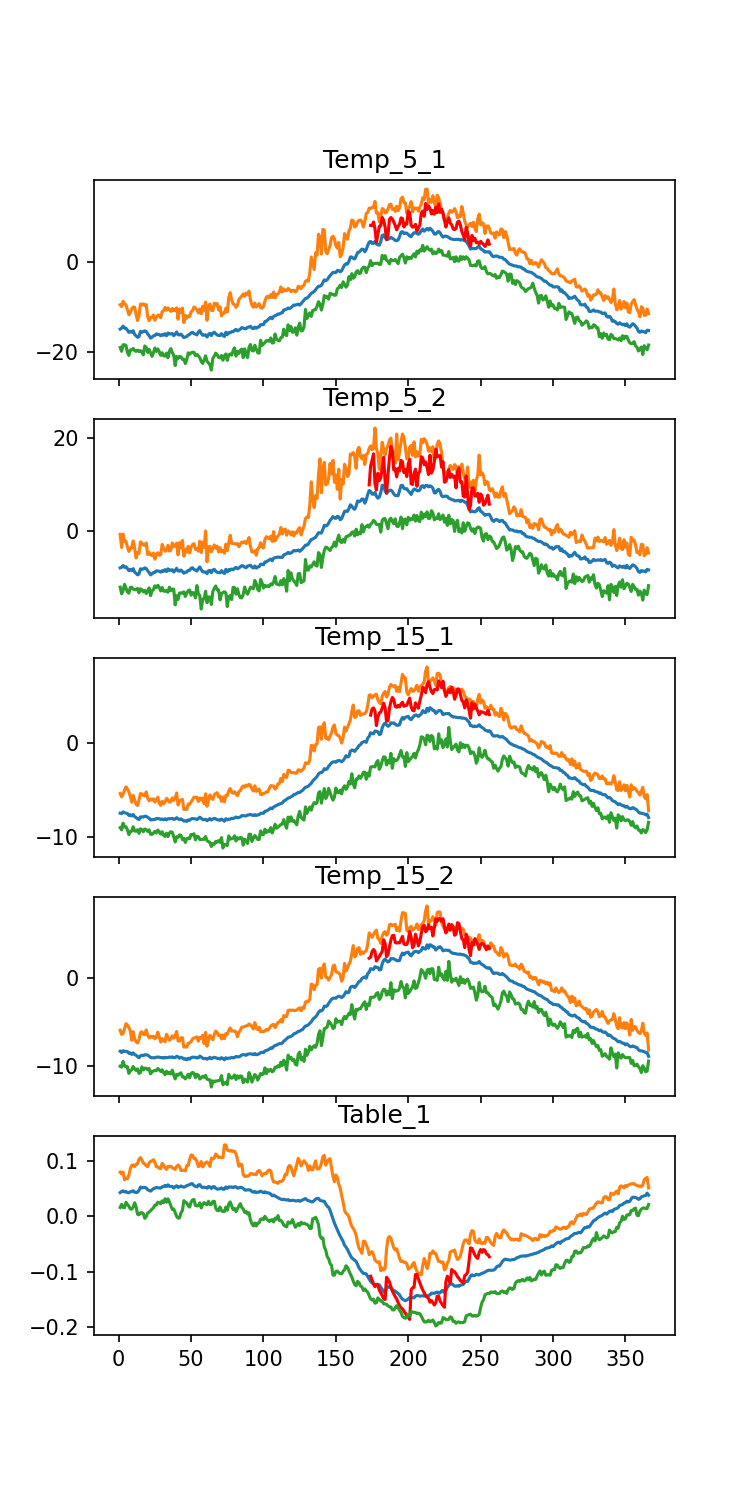

In [30]:
fig,ax=plt.subplots(5,figsize=(5,10),sharex=True)
for i, M in enumerate(Mods):#.keys():
    Y = M#[0]
    ax[i].plot(Data.groupby(Data.index.dayofyear).mean()[Y+'_OLS'].dropna())
    ax[i].plot(Data.groupby(Data.index.dayofyear).max()[Y+'_OLS'].dropna())
    ax[i].plot(Data.groupby(Data.index.dayofyear).max()[Y].dropna(),color='r')
    ax[i].plot(Data.groupby(Data.index.dayofyear).min()[Y+'_OLS'].dropna())
    ax[i].set_title(Y)
# # Rec.set_index(['Y','R2','RMSE']).T

# print((Data[ERA5+['Table_1']].corr()['Table_1']**2).round(2))

<IPython.core.display.Javascript object>


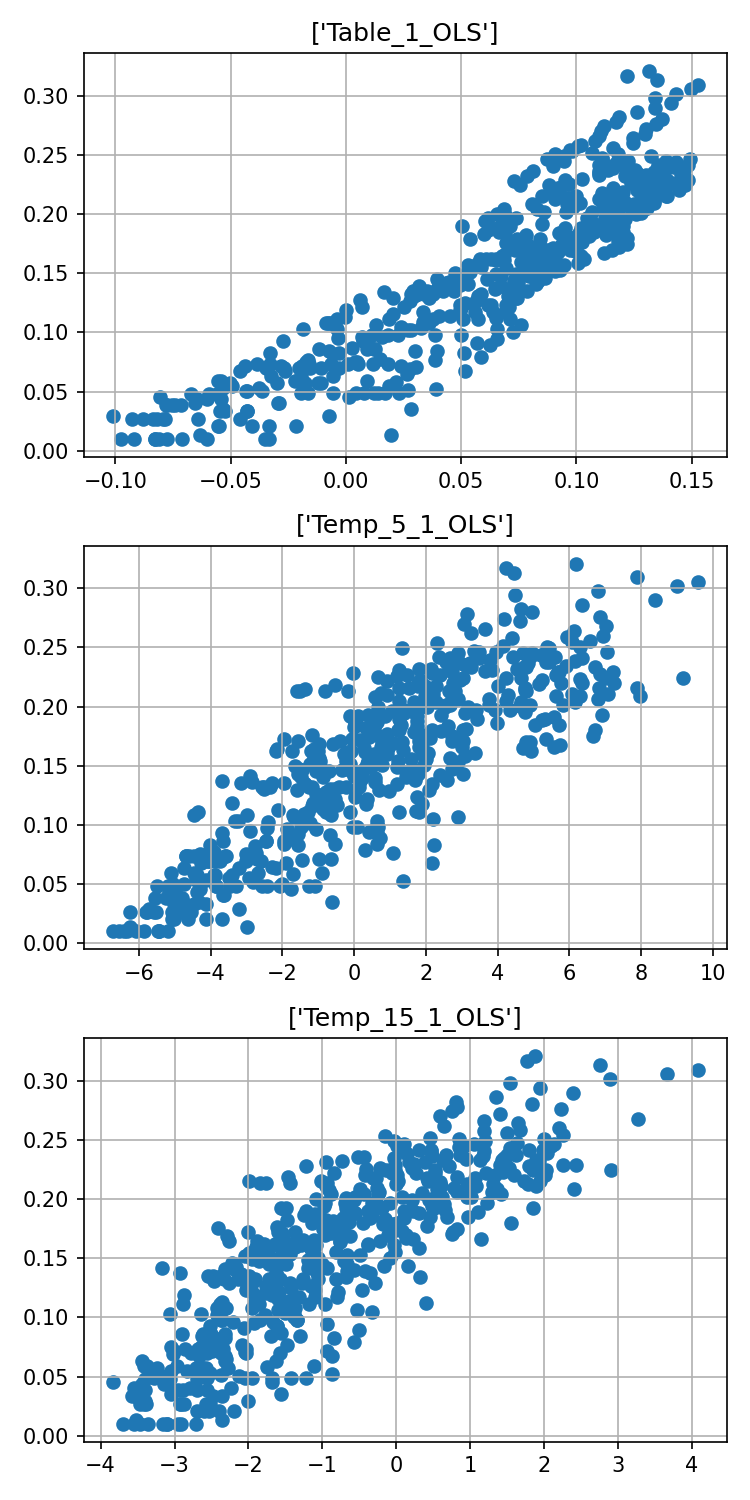

const          0.003630
Table_1_OLS    0.042367
dtype: float64
const           0.003293
Temp_5_1_OLS    0.000933
dtype: float64
const            0.003788
Temp_15_1_OLS    0.002109
dtype: float64


,X,m,b,r2,RMSE
y,,,,,
Active_Layer_1_fit,Table_1_OLS,1.065,0.087,0.826,0.030
Active_Layer_1_fit,Temp_5_1_OLS,0.018,0.141,0.726,0.037
Active_Layer_1_fit,Temp_15_1_OLS,0.039,0.186,0.720,0.038


In [31]:

Early = Data.loc[(((Data.index.month ==6)|(Data.index.month == 5 ))&(Data['Active_Layer_1_fit'] > 0 ))].resample('D').mean()[[
   'Table_1_OLS','Temp_5_1_OLS','Temp_5_2_OLS','Temp_15_1_OLS','Temp_15_2_OLS','snow_cover', 'NDSI_FI_LCP',
    'Active_Layer_1_fit','Air_Temp']].dropna()


i=0

Early['Table_1_OLS']*=-1

Sry = {
    'y':[],
    'X':[],
    'm':[],
    'b':[],
    'r2':[],
    'RMSE':[],
}

# fig,ax=plt.subplots()
fig,ax=plt.subplots(3,figsize=(5,10))

for i,x in enumerate(['Table_1_OLS','Temp_5_1_OLS','Temp_15_1_OLS']):#,'Air_Temp']:
#     X = [x] 
    y='Active_Layer_1_fit'
    
    Sry['X'].append(x)
    X = [x]
    DNA=Early[[y]+X].dropna()
    Sry['y'].append(y)
    X2 = sm.add_constant(DNA[X], has_constant='add')
    est = sm.OLS(DNA[y], X2)
    est = est.fit()    
    Sry['r2'].append(est.rsquared_adj)
    Sry['b'].append(est.params['const'])
    Sry['m'].append(est.params[x])
    print((est.conf_int()[1]-est.conf_int()[0])/2)
    
    ax[i].scatter(Early[X],Early[y])
    ax[i].set_title(X)
    
    DNA['P'] = est.predict(X2)
    if y =='PPFD_Avg':
        DNA.loc[DNA['P']<DNA[y].min(),'P']=DNA[y].min()
#         print('DIff ',metrics.mean_squared_error(DNA[y],DNA['P'])**.5)
    
    Sry['RMSE'].append(metrics.mean_squared_error(DNA[y],DNA['P'])**.5)
    
    if y == 'NR_Wm2_Avg' or y == 'PPFD_Avg' or y == 'wind_speed':
        print(y)
        print('Scale')
        print(y+'_AWS_Scaled')
        Data[y+'_AWS_Scaled'] = est.predict(Data[['const']+X])
    ax[i].grid()
plt.tight_layout()

Summary = pd.DataFrame(Sry)
Summary = Summary.set_index('y')
Summary.round(3)

In [32]:
print((Data['NDSI_FI_LCP']-Data['NDWI_FI_LCP']).describe())

r_pvalues(Data[['NDSI_FI_LCP','NDWI_FI_LCP']])
print(Data['fco2'].dropna())

count    5096.000000
mean        0.362101
std         0.358177
min        -0.162736
25%         0.015858
50%         0.231297
75%         0.740120
max         0.893889
dtype: float64
2017-06-23 00:00:00-06:00    0.617167
2017-06-23 01:00:00-06:00    0.498596
2017-06-23 02:00:00-06:00    0.934849
2017-06-23 04:00:00-06:00    0.851443
2017-06-23 05:00:00-06:00    0.494126
                               ...   
2017-09-13 02:00:00-06:00    0.654927
2017-09-13 08:00:00-06:00    0.356200
2017-09-13 09:00:00-06:00    0.106281
2017-09-13 10:00:00-06:00   -0.211396
2017-09-13 11:00:00-06:00   -0.627347
Name: fco2, Length: 1164, dtype: float64


In [33]:
Data['NDSI_FI_LCP']=Data['NDSI_FI_LCP'].interpolate()
Bad_TD = Data.loc[((Data['Table_1_OLS']*-1>Data['Active_Layer_1_fit'])&(Data['Active_Layer_1_fit']>0)),
         ['Table_1_OLS','Active_Layer_1_fit','snow_cover','NDSI_FI_LCP']]#=-Data.loc[Data['Table_1_OLS']*-1>Data['Active_Layer_1_fit'],'Active_Layer_1_fit']


# plt.figure()
# print(Bad_TD.groupby(Bad_TD.index.year).mean()[['snow_cover','NDSI_FI_LCP','Table_1_OLS','Active_Layer_1_fit']]).round(2)
Bad_TD

,Table_1_OLS,Active_Layer_1_fit,snow_cover,NDSI_FI_LCP
2010-05-25 01:00:00-06:00,-0.016855,0.001146,1.143443,0.912316
2010-05-25 02:00:00-06:00,-0.016787,0.002292,1.143443,0.911856
2010-05-25 03:00:00-06:00,-0.016504,0.003437,1.143443,0.911396
2010-05-25 04:00:00-06:00,-0.016620,0.004583,1.143450,0.910937
2010-05-25 05:00:00-06:00,-0.016830,0.005729,1.143450,0.910477
2010-05-25 06:00:00-06:00,-0.017218,0.006875,1.143443,0.910017
2010-05-25 07:00:00-06:00,-0.017443,0.008021,1.143443,0.909557
2010-05-25 08:00:00-06:00,-0.016681,0.009166,1.142531,0.909098
2010-05-25 09:00:00-06:00,-0.016588,0.010312,1.134856,0.908638
2010-05-25 10:00:00-06:00,-0.016574,0.011458,1.096630,0.908178


# Outputs

In [49]:
# Data.loc[((Data['Table_1_OLS']*-1>Data['Active_Layer_1_fit'])&(Data['Active_Layer_1_fit']==0)),
#      'Table_1_OLS',]=-Data.loc[Data['Table_1_OLS']*-1>Data['Active_Layer_1_fit'],'Active_Layer_1_fit']

Data['Season_Class'] = 'Excluded'
Data.loc[((Data.index.dayofyear<169)),['Season_Class','xi']] = 'Early_Season',1
Data.loc[((Data.index.dayofyear>264)),['Season_Class','xi']] = 'Late_Season',3
Data.loc[((Data.index.dayofyear>=169)&(Data.index.dayofyear<=264)),['Season_Class','xi']] = 'Mid_Season',2
Data.loc[(Data['Study_Season']!=1),['Season_Class','xi']]='Excluded',np.nan


print(Data['fco2'].dropna())

cols =['fch4','fco2','ch4_flux','co2_flux',
       
       'Air_Temp','Air_Temp_ERA5_Scaled','Rainfall',
       
       'Wind_Speed','Wind_Direction','wind_speed_AWS_Scaled','u*_curve2',
       
       'NR_Wm2_Avg_AWS_Scaled','Net_SW','Net_LW','Net_RN','PPFD_Avg_AWS_Scaled',
       
       
       'Daytime',
#        'temperature_2m','dewpoint_temperature_2m',
#        'volumetric_soil_water_layer_1','volumetric_soil_water_layer_2',
       
#        'soil_temperature_level_1','soil_temperature_level_2',
#        'soil_temperature_level_3',
       'DOY',
       
       'NDSI_FI_LCP','NDVI_FI_LCP','NDWI_FI_LCP',
       'snow_cover',
       
       'Polygon','Rim','Polygon_Obs','Rim_Obs',
       
       'VPD_RF',
       'Temp_5_1_OLS',
       'Temp_15_2_OLS',
       'Temp_15_1_OLS',
       'Temp_5_2_OLS',
       
       'Table_1_OLS',
       'Active_Layer_1_fit',
       'Study_Season',#'Warm','Snow_Class',
       'NN_Upscale',
       'NEE_FSO','NME_FSO',#'Season_Sum','Season_Root',
       'VPD_ERA5',
       'Season_Class',
       
      'Daytime',
      ]


RN = {'wind_speed_AWS_Scaled':'wind_speed',
      'NR_Wm2_Avg_AWS_Scaled':'NR_Wm2_Avg',
       'Temp_5_1_OLS':'Temp_5_1',
       'Temp_15_2_OLS':'Temp_15_2',
       'Temp_15_1_OLS':'Temp_15_1',
       'Temp_5_2_OLS':'Temp_5_2',
#        'VPD_RF':'VPD',
      'VPD_ERA5':'VPD',
       'PPFD_Avg_AWS_Scaled':'PPFD_Avg',
       'u*_curve2':'u*',
       'Table_1_OLS':'Table_1',
       'Active_Layer_1_fit':'Active_Layer_1',
     }


Data['NN_Upscale'] = np.nan
Data.loc[Data['Daytime'].isnull()==False,'NN_Upscale']=1
# 58.8%	25.6%

# Data['Polygon']=Data['Polygon'].median()
Data['Polygon'] = 0.588 # ALF derrived values
# Data['Rim']=Data['Rim'].median()
Data['Rim'] = 0.256 # ALF derrived values


for col in RN:
#     print(columns)
    Data[RN[col]+'_FO'] = Data[RN[col]].copy()
    Data[RN[col]+'_Diff'] = Data[RN[col]+'_FO']-Data[col]
    cols.append(RN[col]+'_FO')
    cols.append(RN[col]+'_Diff')

# Path = 'G:/My Drive/FishIsland_Outputs/Network_Outputs/Arctic_Sci_8Vars/'
    
Export = Data.copy()
Export.index.name = 'datetime'
Export.index = Export.index.tz_localize(None)
# Export.loc[((Export['Study_Season']==1)&(Export['VPD_(ERA5_TDew)_(AWS_TA)']<0)),'VPD_(ERA5_TDew)_(AWS_TA)']=0
Export = Export.loc[((Export.index.year>=2009)&(Export.index.year<=2019))]

Export[cols].rename(columns=RN).to_csv(Output_Path+'Network_Outputs/Arctic_Sci_8Vars/AWS_FI_VPD_Final.csv')
# Export[cols].rename(columns=RN).to_csv(Output_Path+'Network_Outputs/Arctic_Sci_8Vars/AWS_FI_Long.csv')
# Export[cols].rename(columns=RN).to_csv(Output_Path+'AWS_ecmwf_upscale.csv')
print('Done')

2017-06-23 00:00:00-06:00    0.617167
2017-06-23 01:00:00-06:00    0.498596
2017-06-23 02:00:00-06:00    0.934849
2017-06-23 04:00:00-06:00    0.851443
2017-06-23 05:00:00-06:00    0.494126
                               ...   
2017-09-13 02:00:00-06:00    0.654927
2017-09-13 08:00:00-06:00    0.356200
2017-09-13 09:00:00-06:00    0.106281
2017-09-13 10:00:00-06:00   -0.211396
2017-09-13 11:00:00-06:00   -0.627347
Name: fco2, Length: 1164, dtype: float64
Done


# Test Conditions

In [59]:
# Data.loc[((Data['Table_1_OLS']*-1>Data['Active_Layer_1_fit'])&(Data['Active_Layer_1_fit']==0)),
#      'Table_1_OLS',]=-Data.loc[Data['Table_1_OLS']*-1>Data['Active_Layer_1_fit'],'Active_Layer_1_fit']

Data['Season_Class'] = 'Excluded'
Data.loc[((Data.index.dayofyear<169)),['Season_Class','xi']] = 'Early_Season',1
Data.loc[((Data.index.dayofyear>264)),['Season_Class','xi']] = 'Late_Season',3
Data.loc[((Data.index.dayofyear>=169)&(Data.index.dayofyear<=264)),['Season_Class','xi']] = 'Mid_Season',2
Data.loc[(Data['Study_Season']!=1),['Season_Class','xi']]='Excluded',np.nan


print(Data['fco2'].dropna())

cols =['fch4','fco2','ch4_flux','co2_flux',
       
       'Air_Temp','Air_Temp_ERA5_Scaled','Rainfall',
       
       'Wind_Speed','Wind_Direction','wind_speed_AWS_Scaled','u*_curve2',
       
       'NR_Wm2_Avg_AWS_Scaled','Net_SW','Net_LW','Net_RN','PPFD_Avg_AWS_Scaled',
       
#        'temperature_2m','dewpoint_temperature_2m',
#        'volumetric_soil_water_layer_1','volumetric_soil_water_layer_2',
       
#        'soil_temperature_level_1','soil_temperature_level_2',
#        'soil_temperature_level_3',
       'DOY',
       
       'NDSI_FI_LCP','NDVI_FI_LCP','NDWI_FI_LCP',
       'snow_cover',
       
       'Polygon','Rim','Polygon_Obs','Rim_Obs',
       
       'VPD_RF',
       'Temp_5_1_OLS',
       'Temp_15_2_OLS',
       'Temp_15_1_OLS',
       'Temp_5_2_OLS',
       
       'Table_1_OLS',
       'Active_Layer_1_fit',
       'Study_Season',#'Warm','Snow_Class',
       'NN_Upscale',
       'NEE_FSO','NME_FSO',#'Season_Sum','Season_Root',
       'VPD_ERA5',
       'Season_Class',
       
      'Daytime',
      ]


RN = {'wind_speed_AWS_Scaled':'wind_speed',
      'NR_Wm2_Avg_AWS_Scaled':'NR_Wm2_Avg',
       'Temp_5_1_OLS':'Temp_5_1',
       'Temp_15_2_OLS':'Temp_15_2',
       'Temp_15_1_OLS':'Temp_15_1',
       'Temp_5_2_OLS':'Temp_5_2',
#        'VPD_RF':'VPD',
      'VPD_ERA5':'VPD',
       'PPFD_Avg_AWS_Scaled':'PPFD_Avg',
       'u*_curve2':'u*',
       'Table_1_OLS':'Table_1',
       'Active_Layer_1_fit':'Active_Layer_1',
     }


Data['NN_Upscale'] = np.nan
Data.loc[Data['Daytime'].isnull()==False,'NN_Upscale']=1
# 58.8%	25.6%

# Data['Polygon']=Data['Polygon'].median()
Data['Polygon'] = 0.588 # ALF derrived values
# Data['Rim']=Data['Rim'].median()
Data['Rim'] = 0.256 # ALF derrived values


for col in RN:
#     print(columns)
    Data[RN[col]+'_FO'] = Data[RN[col]].copy()
    Data[RN[col]+'_Diff'] = Data[RN[col]+'_FO']-Data[col]
    cols.append(RN[col]+'_FO')
    cols.append(RN[col]+'_Diff')

# Path = 'G:/My Drive/FishIsland_Outputs/Network_Outputs/Arctic_Sci_8Vars/'
    
Export = Data.copy()
Export.index.name = 'datetime'
Export.index = Export.index.tz_localize(None)
# Export.loc[((Export['Study_Season']==1)&(Export['VPD_(ERA5_TDew)_(AWS_TA)']<0)),'VPD_(ERA5_TDew)_(AWS_TA)']=0
Export = Export.loc[((Export.index.year>=2009)&(Export.index.year<=2019))]

Export = Export[cols].rename(columns=RN).copy()#.to_csv(Output_Path+'Network_Outputs/Arctic_Sci_8Vars/AWS_FI_VPD_Final.csv')
# # print('Done')
# Export.head()
Export['Daytime']

2017-06-23 00:00:00-06:00    0.617167
2017-06-23 01:00:00-06:00    0.498596
2017-06-23 02:00:00-06:00    0.934849
2017-06-23 04:00:00-06:00    0.851443
2017-06-23 05:00:00-06:00    0.494126
                               ...   
2017-09-13 02:00:00-06:00    0.654927
2017-09-13 08:00:00-06:00    0.356200
2017-09-13 09:00:00-06:00    0.106281
2017-09-13 10:00:00-06:00   -0.211396
2017-09-13 11:00:00-06:00   -0.627347
Name: fco2, Length: 1164, dtype: float64


datetime
2009-01-01 00:00:00    0.0
2009-01-01 01:00:00    0.0
2009-01-01 02:00:00    0.0
2009-01-01 03:00:00    0.0
2009-01-01 04:00:00    0.0
                      ... 
2019-12-31 19:00:00    0.0
2019-12-31 20:00:00    0.0
2019-12-31 21:00:00    0.0
2019-12-31 22:00:00    0.0
2019-12-31 23:00:00    0.0
Name: Daytime, Length: 96408, dtype: float64

In [62]:
# N = 1000
Step = 19
N = Step**3
print(N)
Set = Export[0:N].copy()
for v in ['VPD','wind_speed','Active_Layer_1']:
#     print(Data['Daytime'])
#     print(Export['Daytime'])
#     print(Export.loc[(Export['Daytime']==0),v])
    Set[v] = Export.loc[((Export['fco2'].isnull()==False)&(Export['Daytime']==0)),v].median()
    
    
Set['PPFD_Avg'] = Export['PPFD_Avg'].min()
Set['Daytime'] = 0
    
mn,mx=Export.loc[Export['Study_Season']==1,'Temp_5_1'].min(),Export.loc[Export['Study_Season']==1,'Temp_5_1'].max()
print(mn,mx)
T51 = np.linspace(mn,mx,Step)
print(T51)
mn,mx=Export.loc[Export['Study_Season']==1,'Temp_5_2'].min(),Export.loc[Export['Study_Season']==1,'Temp_5_2'].max()
print(mn,mx)
T52 = np.linspace(mn,mx,Step)
print(T52)
mn,mx=Export.loc[Export['Study_Season']==1,'Temp_15_2'].min(),Export.loc[Export['Study_Season']==1,'Active_Layer_1'].max()
print(mn,mx)
AL = np.linspace(mn,mx,Step)
print(AL)


j = 0
k = 0
for i in range(0,N,Step):
    Set.iloc[i:i+Step]['Temp_5_1'] = T51
    Set.iloc[i:i+Step]['Temp_5_2'] = T52[j]
    Set.iloc[i:i+Step]['Temp_15_2'] = AL[k]
    j += 1
    if j >= T52.shape[0]:
        print(j,i)
        j = 0
        k += 1
    if k > AL.shape[0]:
        k = 0
        
        
print(Set)

# Set['Temp_5_1']

# Set['PPFD_Avg'] = 0
# for v in ['wind_speed','Temp_15_2','VPD','Active_Layer_1']:
#     Set[v] = Export.loc[Export['fco2'].isnull()==False,v].median()

6859
-5.03939537502585 16.457194683390956
[-5.03939538 -3.84514037 -2.65088537 -1.45663037 -0.26237536  0.93187964
  2.12613464  3.32038965  4.51464465  5.70889965  6.90315466  8.09740966
  9.29166466 10.48591967 11.68017467 12.87442967 14.06868468 15.26293968
 16.45719468]
-2.9125820494691723 22.027573798525374
[-2.91258205 -1.52701784 -0.14145362  1.24411059  2.62967481  4.01523902
  5.40080323  6.78636745  8.17193166  9.55749587 10.94306009 12.3286243
 13.71418852 15.09975273 16.48531694 17.87088116 19.25644537 20.64200958
 22.0275738 ]
-5.282407905233091 0.5716690465831269
[-5.28240791 -4.95718141 -4.63195491 -4.30672841 -3.98150192 -3.65627542
 -3.33104892 -3.00582242 -2.68059593 -2.35536943 -2.03014293 -1.70491643
 -1.37968994 -1.05446344 -0.72923694 -0.40401045 -0.07878395  0.24644255
  0.57166905]
19 342
19 703
19 1064
19 1425
19 1786
19 2147
19 2508
19 2869
19 3230
19 3591
19 3952
19 4313
19 4674
19 5035
19 5396
19 5757
19 6118
19 6479
19 6840
                     fch4  fco2  

<ipython-input-62-9397025f19dd>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Set.iloc[i:i+Step]['Temp_5_1'] = T51
<ipython-input-62-9397025f19dd>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Set.iloc[i:i+Step]['Temp_5_2'] = T52[j]
<ipython-input-62-9397025f19dd>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [ ]:

Data.loc[Data.index.month==6].resample('Y').sum()['Study_Season']
# Data.loc[Data['Study_Season']==1].resample('Y').last()['Date']
# plt.figure()

print(Data.loc[Data['NR_Wm2_Avg']>400,['Net_RN','NR_Wm2_Avg_AWS_Scaled']].diff(axis=1).describe())


print(Data.loc[Data['NR_Wm2_Avg']>400,['NR_Wm2_Avg_AWS_Scaled','NR_Wm2_Avg']].diff(axis=1).describe())

print(Data.loc[Data['NR_Wm2_Avg']>400,['Net_RN','NR_Wm2_Avg']].diff(axis=1).describe())

In [ ]:

SF = Data.loc[(Data.index.month>=9)&(Data['snow_cover']>=18.75)].resample('Y').first()[['DOY']]
for i,d in SF.iterrows():
#     print(i.year,d.values[0])
    Data.loc[((Data.index.year==i.year)&(Data['DOY']>=d.values[0])),'Study_Year']=np.nan
#     print(i.year,d.values[0])
    Data.loc[((Data.index.year==i.year)&(Data['DOY']>=d.values[0])),'Study_Season']=np.nan


In [ ]:
Yearly = Data.loc[Data['Study_Year']!=5].resample('Y').mean()[['Air_Temp','Air_Temp_ERA5_Scaled']]

# Yearly[['Air_Temp_S','Air_Temp_ERA5_Scale']] = Data.loc[Data['Study_Year']==1].resample('Y').mean()[['Air_Temp','Air_TemERA5_Scale']]

# Yearly[['Air_Temp_L','Air_Temp_L']] = Data.loc[((Data.index.month>=8)&
#                          (Data.index.month<=11))].resample('Y').mean()[['Air_Temp','Air_Temp']]



Yearly[['Peak_NDVI','Peak_Thaw_Depth']] = Data.resample('Y').max()[['NDVI_FI_LCP','Active_Layer_1']]
Yearly[['Start_DOY']] = Data.loc[Data['Study_Season']==1].resample('Y').min()[['DOY']]
Yearly[['End_DOY']] = Data.loc[Data['Study_Season']==1].resample('Y').max()[['DOY']]

# print(Yearly)
for index,row in Yearly.iterrows():
    y =index.year
    Data.loc[((Data.index.year==y)&(Data['DOY']==row['Start_DOY'])),'Start_DOY'] = row['Start_DOY']
    Data.loc[((Data.index.year==y)&(Data['DOY']==row['End_DOY'])),'End_DOY'] = row['End_DOY']

    
Yearly['Melt_Date'] = Daily.loc[Daily['Snow_Class']=='Snow Free'].resample('Y').min()['Date']
Yearly['Melt_DOY'] = Daily.loc[Daily['Snow_Class']=='Snow Free'].resample('Y').min()['DOY']
Yearly['Start_Date'] = Data.loc[Data['Study_Season']==1].resample('Y').min()['Date']
Yearly['Start_doy'] = Data.loc[Data['Study_Season']==1].resample('Y').min()['DOY']
Yearly['GS_Date'] = Data.loc[Data['NDVI_FI_LCP']>=0.25].resample('Y').min()['Date']

Yearly['End_Date'] = Data.loc[Data['Study_Season']==1].resample('Y').max()['Date']
Yearly['End_doy'] = Data.loc[Data['Study_Season']==1].resample('Y').max()['DOY']


Yearly['Melt_DOY'] = Daily.loc[((Daily.index.month<=6)&(Daily.index.month>=5)&(Daily['NDSI_FI_LCP']<0)),
                               ].resample('Y').min()['DOY']
Yearly['Flood_DOY'] = Daily.loc[((Daily.index.month<=6)&(Daily.index.month>=5)&(Daily['NDWI_FI_LCP']<0)),
                               ].resample('Y').min()['DOY']



Yearly['Snow_DOY'] = Daily.loc[((Daily.index.month>=9)&(Daily.index.month<=10)&(Daily['NDSI_FI_LCP']<0)),
                               ].resample('Y').max()['DOY']
Yearly['Snow_DOY_2'] = Daily.loc[((Daily.index.month>=9)&(Daily.index.month<=10)&(Daily['snow_cover']>18.75)),
                               ].resample('Y').min()['DOY']
# Yearly['Flood_doy_start'] = Daily.loc[((Daily['Flood_Class']=='Possible')
#                                  |
#                                  (Daily['Flood_Class']=='Probable')
#                                 )].resample('Y')['DOY'].min()

# Yearly['Flood_doy_end'] = Daily.loc[((Daily['Flood_Class']=='Possible')
#                                  |
#                                  (Daily['Flood_Class']=='Probable')
#                                 )].resample('Y')['DOY'].max()
# Yearly['Flood_doy'] = Data.loc[Data['Study_Year']==1].resample('Y').max()['DOY']


Yearly['Duration'] = Yearly['End_doy']-Yearly['Start_doy']


Yearly['Snowmelt']=pd.to_datetime(Yearly['Melt_Date']).dt.strftime('%d %b')
Yearly['Study_Start']=pd.to_datetime(Yearly['Start_Date']).dt.strftime('%d %b')#'%b-%d')
Yearly['Study_End']=pd.to_datetime(Yearly['End_Date']).dt.strftime('%d %b')

Yearly.round(2)
Yearly['Study Season'] = Yearly['Study_Start']+' - '+Yearly['Study_End']#

# Yearly
Yearly.index = Yearly.index.year
# plt.figure()
# Yearly[['Start_doy','End_doy']].boxplot(column=['Start_doy','End_doy'])
print(Yearly[['Start_doy','End_doy','Duration']].describe())
Yearly[['Study Season','Duration','Air_Temp','Start_doy','End_doy']]


# p

from scipy.stats.mstats import theilslopes
for v in ['End_doy','Start_doy','Duration','Air_Temp_ERA5_Scaled','Peak_NDVI','Melt_DOY','Snow_DOY',
'Snow_DOY_2',
'Flood_DOY']:
    print()
    print(v)
    print(theilslopes(Yearly[v],alpha=0.95))
    
plt.figure()
plt.scatter(Yearly.index,Yearly['Start_doy'])

In [ ]:
# Yearly['Flood_doy_end']

print(Yearly['End_DOY'].max()-Yearly['End_DOY'].min())
Yearly['End_DOY'].describe()

E = 0
M = 0
for d in Daily.loc[Daily['Study_Season']==1].resample('Y').last()['Date']:
#     print(d)
    V = (Daily.loc[Daily['Date'].shift()==d,['NDSI_FI_LCP','snow_cover']])
    if V['NDSI_FI_LCP'].values>0:
        M += 1
    else:
        E += 1
print(M,E)

In [ ]:

S1 = Yearly.loc[((Yearly.index>2008)&(Yearly.index<2020))]
S2 = Yearly.loc[((Yearly.index<=2008)|(Yearly.index==2020))]

D1 = Data.loc[((Data['Study_Season']==1)&(Data.index.year>2008)&(Data.index.year<2020))]
D2 = Data.loc[((Data['Study_Season']==1)&((Data.index.year<=2008)|(Data.index.year==2020)))]


print(Data.loc[Data.index.month==10].resample('Y').mean()['Air_Temp'].describe())

print('Season')
print(D1.describe()['Air_Temp_ERA5_Scaled'])
print("Not Season")
print(D2.describe()['Air_Temp_ERA5_Scaled'])

print('Season')
print(S1.describe()[['Air_Temp_ERA5_Scaled','Duration']])
print("Not Season")
print(S2.describe()[['Air_Temp_ERA5_Scaled','Duration']])

r,p=r_pvalues(Yearly[['Air_Temp','Duration']])
r[p>0.05]=np.nan
r**2
print(r
)

fig,axes = plt.subplots(1,figsize=(5,3),sharex=True)
ax = [axes]
ax[0].bar(S2.index,S2['End_doy']-S2['Start_doy'],bottom=S2['Start_doy'],
#           width = 1,
#           edgecolor='k',facecolor='#75d7e6')
#           width = 200,
          edgecolor='k',facecolor='#d6d6d6')
ax[0].bar(S1.index,S1['End_doy']-S1['Start_doy'],bottom=S1['Start_doy'],
#           width = 1,
          edgecolor='k',facecolor='#75d7e6')
# ax[0].bar(S1.index,S1['Flood_doy_end']-S1['Flood_doy_start'],bottom=S1['Flood_doy_start'],
# #           width = 1,
#           edgecolor='k',facecolor='#75d7e6')



ax[0].set_ylim(140,305)
ax[0].set_axisbelow(True)
ax[0].grid()
ax[0].set_ylabel('Day of Year')
ax[0].set_title('Snow Free Season Length',loc='left')
ax[0].axhspan(161,161,facecolor=[.97,.97,.97,.0],
              edgecolor='r',linestyle='--')
ax[0].axhspan(254,254,facecolor=[.97,.97,.97,.0],
              edgecolor='r',linestyle='--')

plt.tight_layout()
plt.savefig(G_Drive+'PhD_Thesis\\Chapter3_Figs/LongRecord.png',dpi=600)

In [ ]:
F = Data.resample('D').max()[['NDWI_FI_LCP','Air_Temp_ERA5_Scaled']]

# Data['NDWI_FI_LCP'].max()

F['Flood_Class'] = 'Not Flooded'
F.loc[(((F.index.month==5)|((F.index.month==6)))&(F['NDWI_FI_LCP']>0.075)),'Flood_Class']='Possible'
# Data.loc[(((Data.index.month==5)|((Data.index.month==6)))&(F['Flood']>0.1)),'Flood_Class']='Possible'
F.loc[(((F.index.month==5)|((F.index.month==6)))&(F['NDWI_FI_LCP']>0.15)),'Flood_Class']='Probable'
F['Year'] = F.index.year
Fy = F.groupby(['Year','Flood_Class']).max()['NDWI_FI_LCP']


Fy.unstack().round(2)

In [ ]:
# print(FDF)

Vals = {'Year':[],
       'KULUARPAK_NDWI':[],
       'BIG_LAKE_NDWI':[]}

for i, row in FDF.iterrows():
    Vals['Year'].append(i)
#     print(i,row['KULUARPAK_Peak_Date'])
    Vals['KULUARPAK_NDWI'].append(Data.loc[Data.index.date==row['KULUARPAK_Peak_Date'],'NDWI_FI_LCP'].max())
    Vals['BIG_LAKE_NDWI'].append(Data.loc[Data.index.date==row['BIG_LAKE_Peak_Date'],'NDWI_FI_LCP'].max())
Vals = pd.DataFrame(data=Vals)
print(Vals)

In [ ]:

print(Data.loc[Data.index.year==2009,'co2_flux'])

In [ ]:

G = (Data.loc[((Data['Study_Season']==1)&(Data['dewpoint_temperature_2m']<=Data['Tdew']-2)),
               ['dewpoint_temperature_2m','Tdew']])
G.groupby(G.index.hour).count()

a,b='dewpoint_temperature_2m','Tdew'
DNA = Data[[a,b]].dropna()
print((DNA[a]-DNA[b]).describe())

print(metrics.mean_squared_error(DNA[a],DNA[b])**.5)

In [63]:
print(FDF)

           Start  Start_doy  Start_NDSI   End_Flood  End_Flood_doy  \
2000  2000-06-13        165  2000-06-13  2000-06-11            164   
2001  2001-06-10        161  2001-06-12  2001-06-09            161   
2002  2002-06-01        152  2002-06-05  2002-06-04            156   
2003  2003-06-02        153  2003-06-10  2003-06-08            160   
2004  2004-06-07        159  2004-06-09  2004-06-07            160   
2005  2005-06-05        156  2005-05-31  2005-05-28            149   
2006  2006-06-03        154  2006-06-04  2006-06-01            153   
2007  2007-06-03        154  2007-05-31  2007-05-29            150   
2008  2008-06-05        157  2008-05-31  2008-05-29            151   
2009  2009-06-04        155  2009-06-10  2009-06-08            160   
2010  2010-05-28        148  2010-06-02  2010-05-31            152   
2011  2011-05-27        147  2011-06-02  2011-05-31            152   
2012  2012-06-01        153  2012-06-02  2012-05-31            153   
2013  2013-06-11    